In [150]:
import os 
from scipy.interpolate import interp1d
sims = os.listdir('./')
sims = [i for i in sims if 'x' in i]
sims = [i for i in sims if '.txt' not in i]
sims = [i for i in sims if '.pkl' not in i]
simsnames = [i.split('_')[0][1:] for i in sims]



In [151]:
from HeaderP import *
import pynbody as pb
import pynbody.filt as filt
import os, pickle, glob
from itertools import combinations_with_replacement

In [152]:
def readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=True):
    if disk:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    else:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    data['R']=np.sqrt((data['x'])**2+data['y']**2)
    
    if Rcut:
        data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['zbir'])<zcut_thread].reset_index(drop=True)
    data['dR']=data['R']-data['Rbir']
    data['dz']=abs(data['z'])-abs(data['zbir'])
    if disk:
        data = data.loc[(data['decomp']==1)|(data['decomp']==4)].reset_index()
    return data

def normalize_data(data):
    return (data-np.mean(data))/np.std(data)

def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

In [153]:
def calcRbir_cv(data, fold=5, rescale=True):
    fold = int(fold)
    if rescale:
        args = normalize_data(data['feh']), normalize_data(data['age'])
    else:
        args = data['feh'], data['age']
    args_name = '[Fe/H]', 'τ'
    
    X = list(args)
    X_names = list(args_name)
    
    if rescale:
        for a, b in combinations_with_replacement(args, 2):
            X.append(normalize_data(a * b))
    else:
        for a, b in combinations_with_replacement(args, 2):
            X.append(a * b)

    
    for a, b in combinations_with_replacement(args_name, 2):
        X_names.append(str(a + '*' + b))
        
    X = np.array(X).T


    # Define the number of training and validating stars.
    Ntest = int(1./float(fold)*np.shape(X)[0])
    y = data['Rbir'].values
    yave = np.mean(y)
    ystd = np.std(y)
    y = (y-yave)/ystd
    ypred = np.zeros(len(y))
    
    shuffle_inds = np.arange(len(y))
    np.random.shuffle(shuffle_inds)
        
    weights = np.zeros((len(X_names)+1, fold))
        
    for i in range(fold):
        if i == fold-1:
            startind = int(-Ntest)
            endind = int(len(shuffle_inds)-1)
        else:
            startind = int(i*Ntest)
            endind = int(Ntest*(i+1))
            
        train_inds = np.append(shuffle_inds[:startind],shuffle_inds[endind:])
        test_inds = shuffle_inds[startind:endind]
        y_train, X_train = y[train_inds], X[train_inds, :]
        y_test, X_test = y[test_inds], X[test_inds, :]

        weights[:, i] = train(y_train, X_train)

        A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
        #print(np.shape(weights[:, i]))
        y_predict = np.dot(weights[:, i].T, A.T)
        ypred[test_inds] = y_predict

    return np.append(['$θ_C$'],X_names), [np.mean(weights[i,:]) for i in range(len(X_names)+1)], [np.std(weights[i,:]) for i in range(len(X_names)+1)], y, ypred

def calcRstd(data, Rbirbin=np.linspace(0,10,20), norm=True):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    
    if norm:
        ymean = np.mean(data['Rbir'].dropna())
        ystd = np.std(data['Rbir'].dropna())

        data['Rbir_norm'] = (data['Rbir']-ymean)/ystd
        data['R_norm'] = (data['R']-ymean)/ystd
        
    for i in range(len(Rbirbin)-1):
        
        if norm:
            data_loc = data.loc[(data['Rbir_norm']>Rbirbin[i])&(data['Rbir_norm']<Rbirbin[i+1])].reset_index(drop=True)
            Rstds[i] = (np.std(data_loc['R_norm']-data_loc['Rbir_norm'])-ymean)/ystd
        else:
            data_loc = data.loc[(data['Rbir']>Rbirbin[i])&(data['Rbir']<Rbirbin[i+1])].reset_index(drop=True)
            Rstds[i] = np.std(data_loc['R']-data_loc['Rbir'])
            
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rstds

def calcRstd_inf(infRbir, trueRbir, Rbirbin=np.linspace(0,10,20)):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    for i in range(len(Rbirbin)-1):
        m = (trueRbir>Rbirbin[i])&(trueRbir<Rbirbin[i+1])
        Rstds[i] = np.std(trueRbir[m]-infRbir[m])
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rstds

def predNew(weights, data, rescale=True):
    weights = np.array(weights)
    if rescale:
        args = normalize_data(data['feh']), normalize_data(data['age'])
    else:
        args = data['feh'], data['age']
        
    X = list(args)
    if rescale:
        for a, b in combinations_with_replacement(args, 2):
            X.append(normalize_data(a * b))
    else:
        for a, b in combinations_with_replacement(args, 2):
            X.append(a * b)
    X = np.array(X).T
    y = normalize_data(data['Rbir'].values)
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)
    y_predict = np.dot(weights.T, A.T)
    return y, y_predict


Use 6.96e11

In [174]:
i=0
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
print('Finished reading in simulation...')

print('Calculating weights...')
allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
print('Finished calculating weights...')


Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


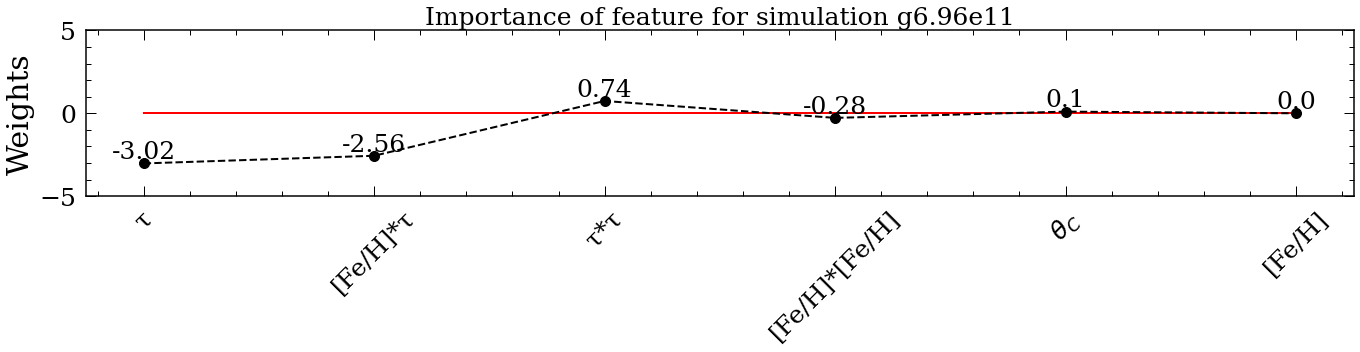

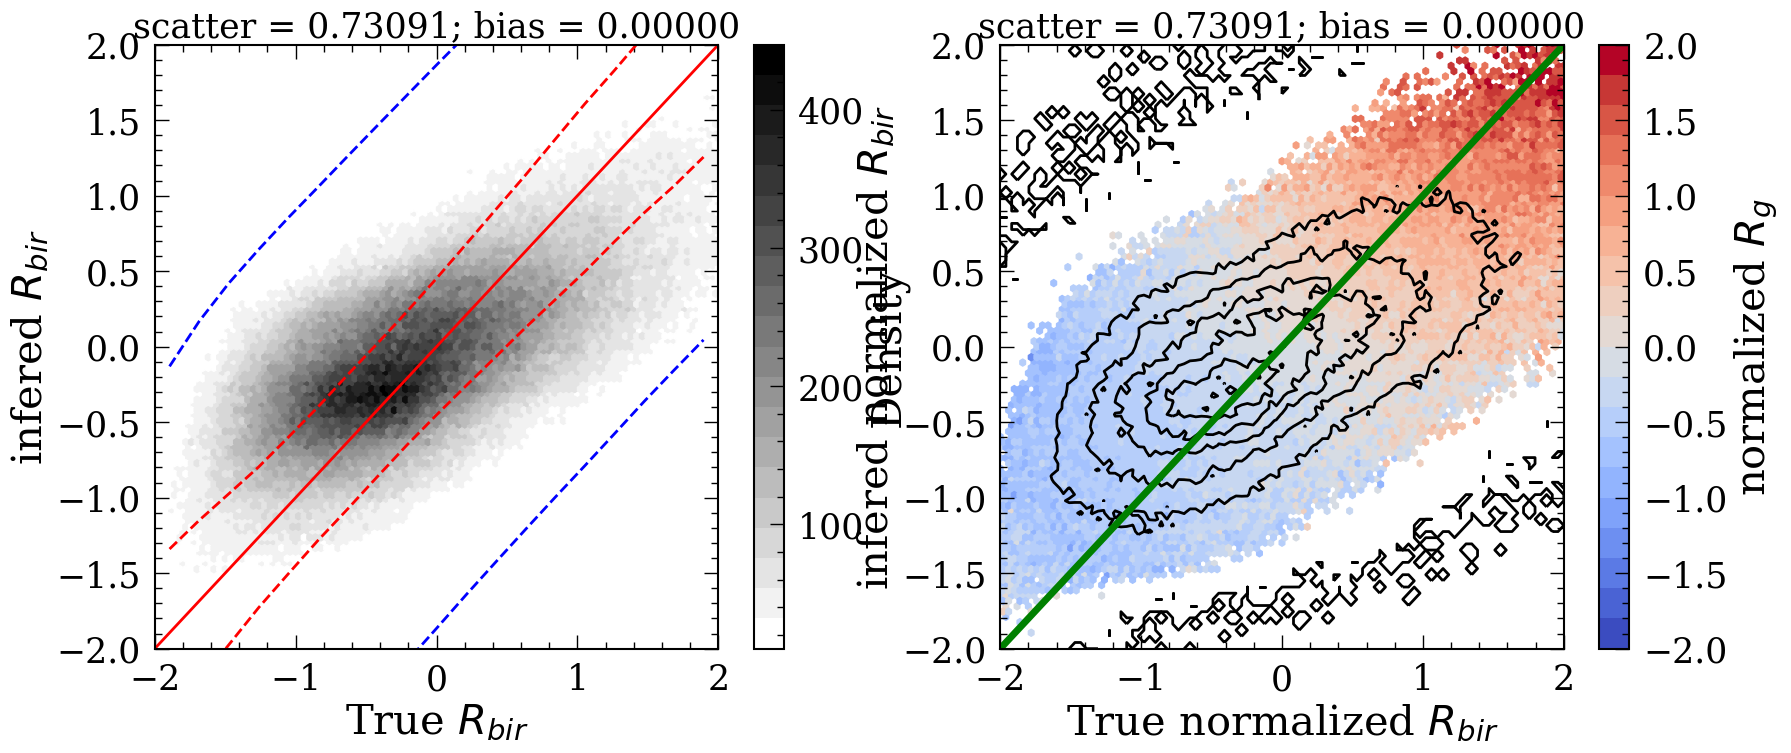

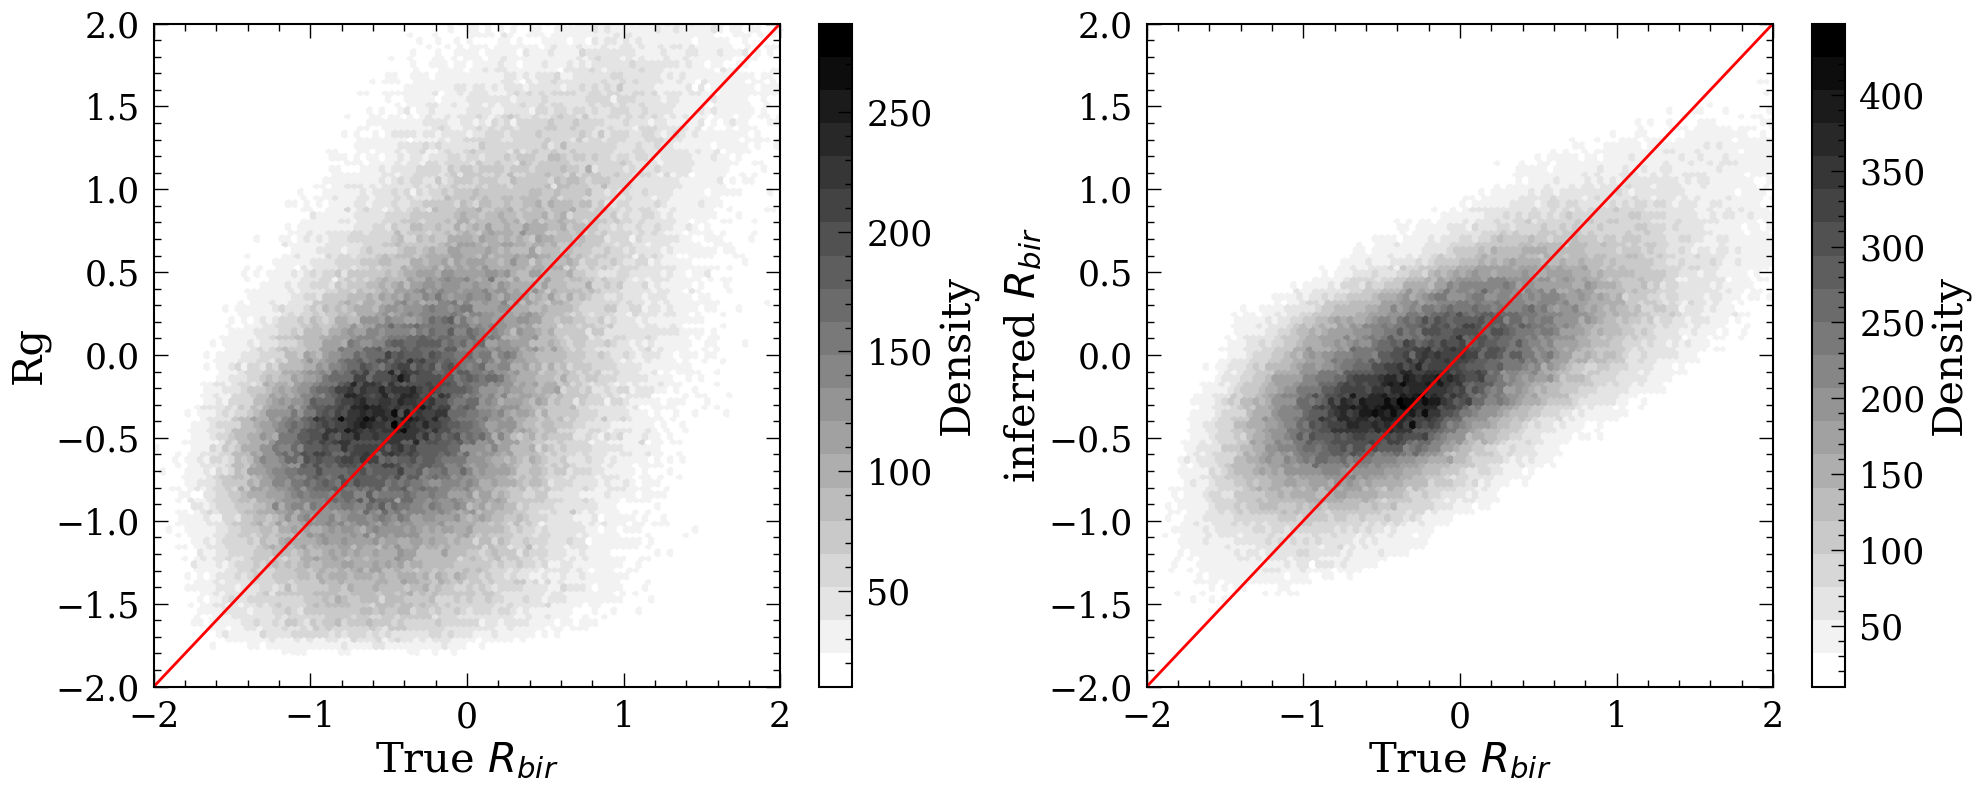

In [176]:
plt.figure(figsize=(19,5))
absweights, weights_imp, weights_imp_err, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.errorbar(range(len(allnames)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
plt.plot(range(len(allnames)),np.zeros(len(allnames)),'r-')
plt.xticks(range(len(allnames)), allnames, rotation=45)
#plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-5,5])
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(-2, 2, 100)


plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))

plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
cmap1 = plt.cm.get_cmap('coolwarm',20)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
plt.hexbin(y, ypred, C = normalize_data(data['Rg'].values), extent = (-2,2,-2,2), gridsize = 100, 
           cmap = cmap1, vmin = -2, vmax = 2, mincnt=10)
plt.plot(xs, xs, "g-", linewidth=5)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True normalized $R_{bir}$")
plt.ylabel("infered normalized $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('normalized $R_g$')
from matplotlib.colors import LogNorm
counts,xbins,ybins=np.histogram2d(y, ypred, bins = (np.linspace(-2,2,100),np.linspace(-2,2,100)))
plt.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),
    ybins.min(),ybins.max()],linewidths=2,colors='black',
    linestyles='solid')

plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
plt.hexbin(normalize_data(data['Rbir']), normalize_data(data['Rg']), 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("Rg")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
plt.hexbin(y, ypred, 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("inferred $R_{bir}$")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.tight_layout()

  0%|          | 0/6 [00:00<?, ?it/s]

8.26e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 2/6 [00:26<00:52, 13.10s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [00:54<00:58, 19.47s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 83%|████████▎ | 5/6 [02:20<00:32, 32.22s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6/6 [02:56<00:00, 29.47s/it]


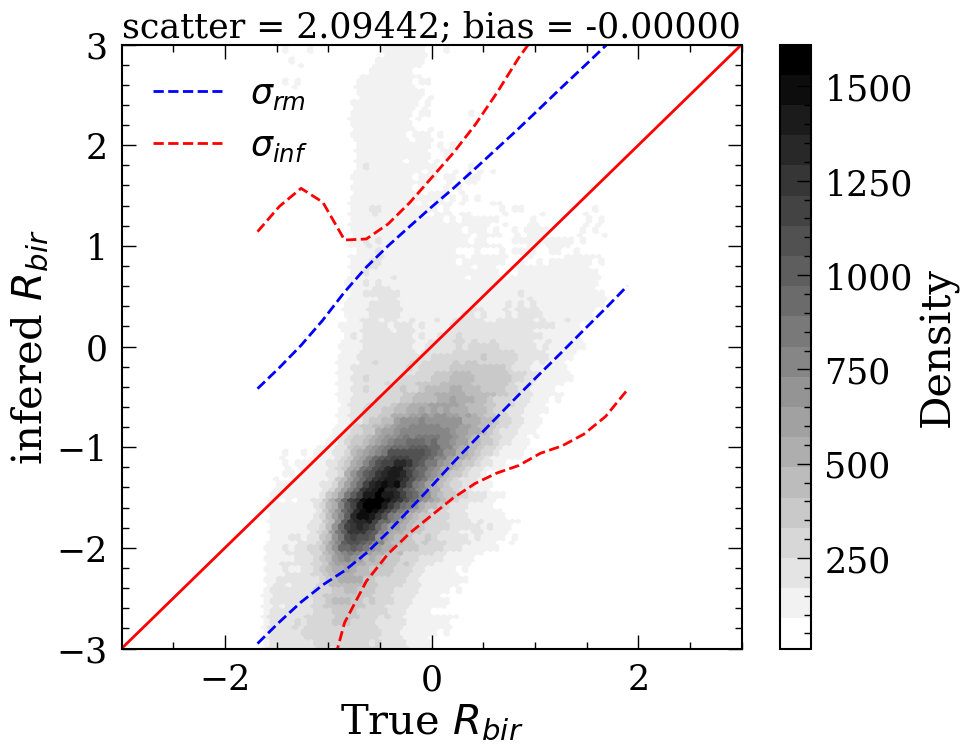

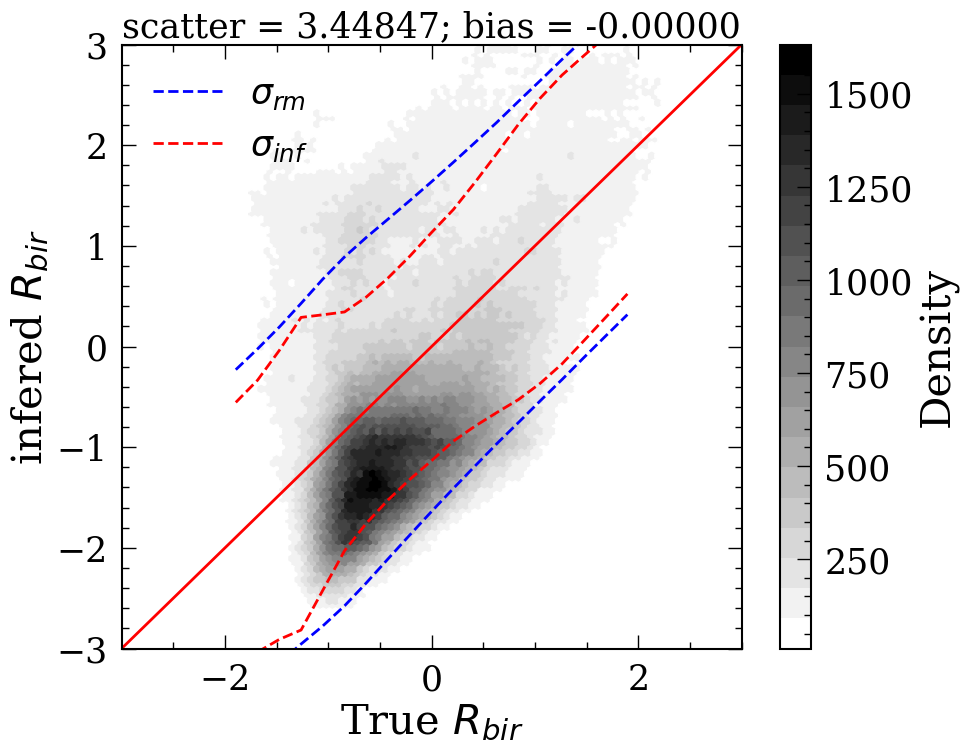

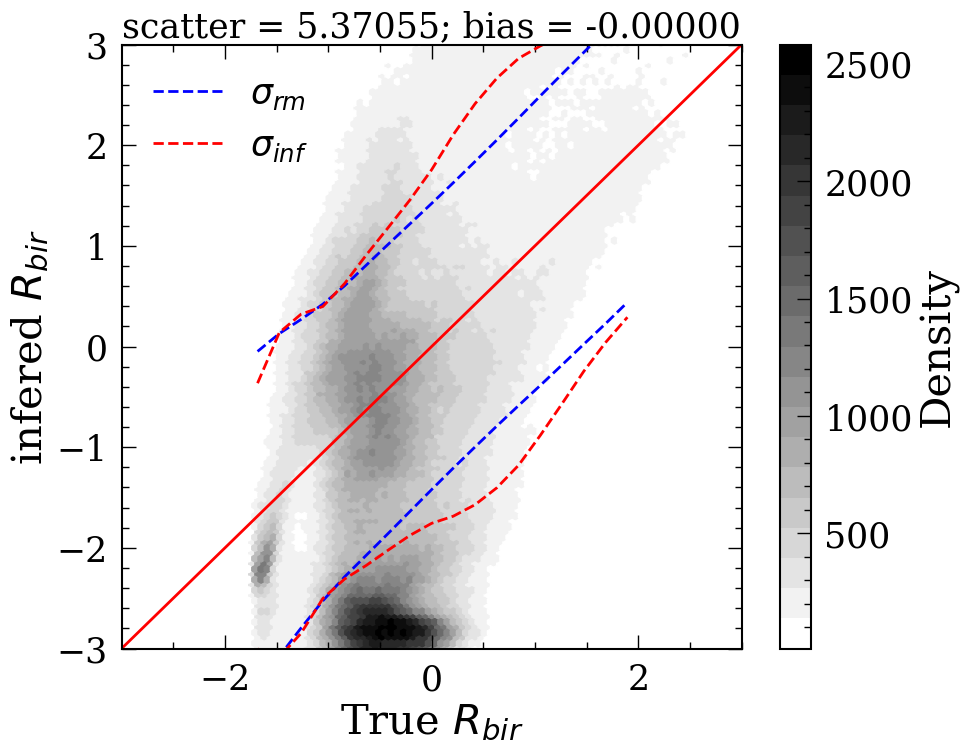

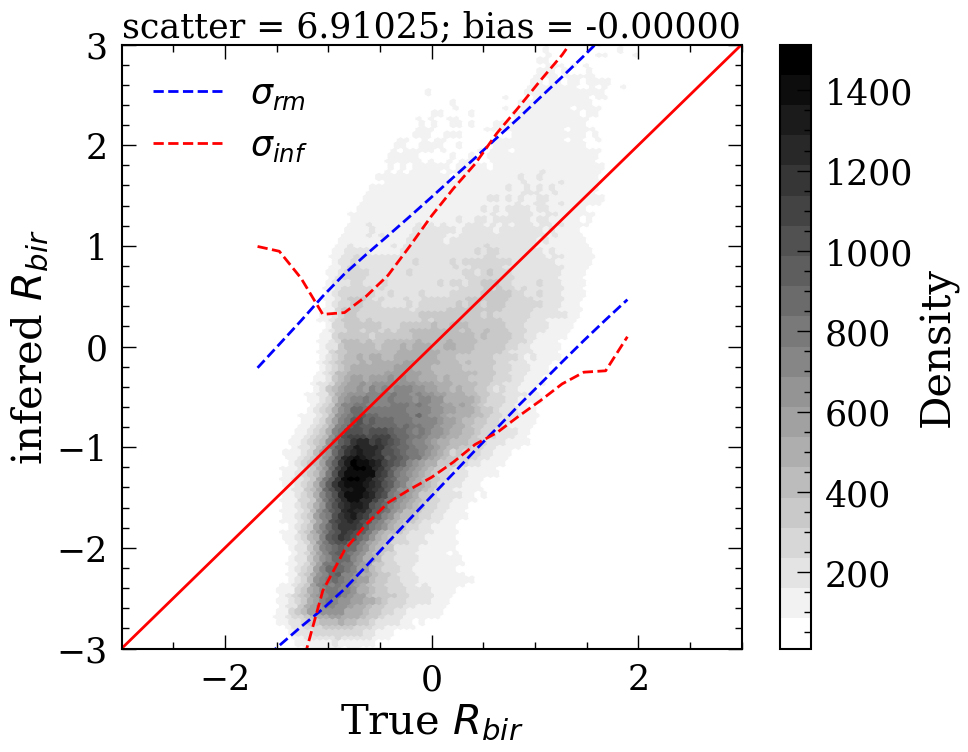

In [177]:
cmap = plt.cm.get_cmap('binary',20)
scatter, bias = 0, 0
for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12' or simsnames[i]==simNo:
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=15
    zcut_thread=5
    
    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')

    y, ypred = predNew(weights, data)
    
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)+scatter
    bias  = np.mean(y-ypred)+bias
    
    plt.hexbin(y, ypred, extent=(-3,3,-3,3),gridsize=100, mincnt=10, cmap=cmap)
    Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
    Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))
    plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
    plt.plot(Rbirs, Rbirs-Rstds, 'b--')
    plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
    plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
    plt.plot([-3, 3], [-3, 3], "r-")
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    plt.legend()
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth_predW_model_disk'+simsnames[0]+'.png')
scatter = scatter/4
bias = bias/4

out696 = pd.DataFrame(np.array((np.append(allnames,['scatter','bias','scatter_pred','bias_pred']), 
                               np.append(weights,[np.std(y-ypred),np.mean(y-ypred),scatter,bias]), 
                               np.append(weights_err,[0, 0, 0, 0]))).T,
                      columns=['names','w696','w_err696'])

Use 8.26e11

In [178]:
i=1
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
print('Finished reading in simulation...')

print('Calculating weights...')
allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
print('Finished calculating weights...')


Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


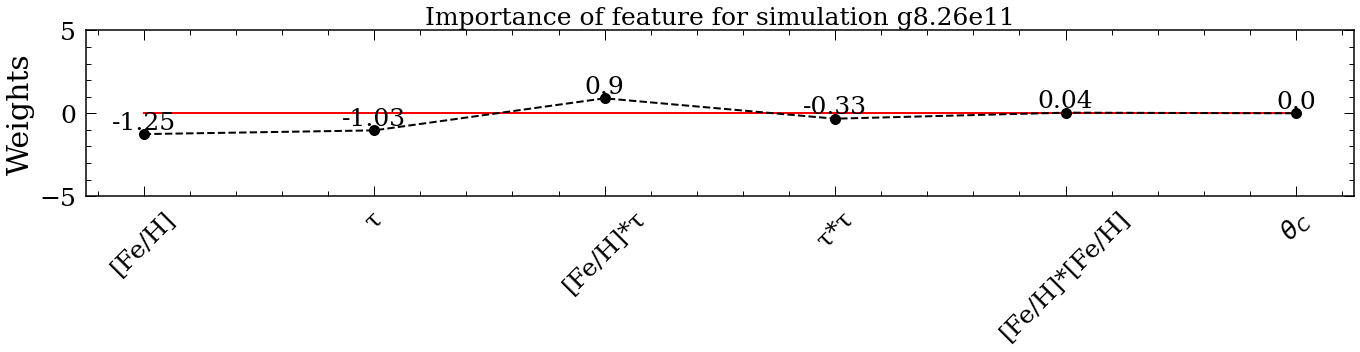

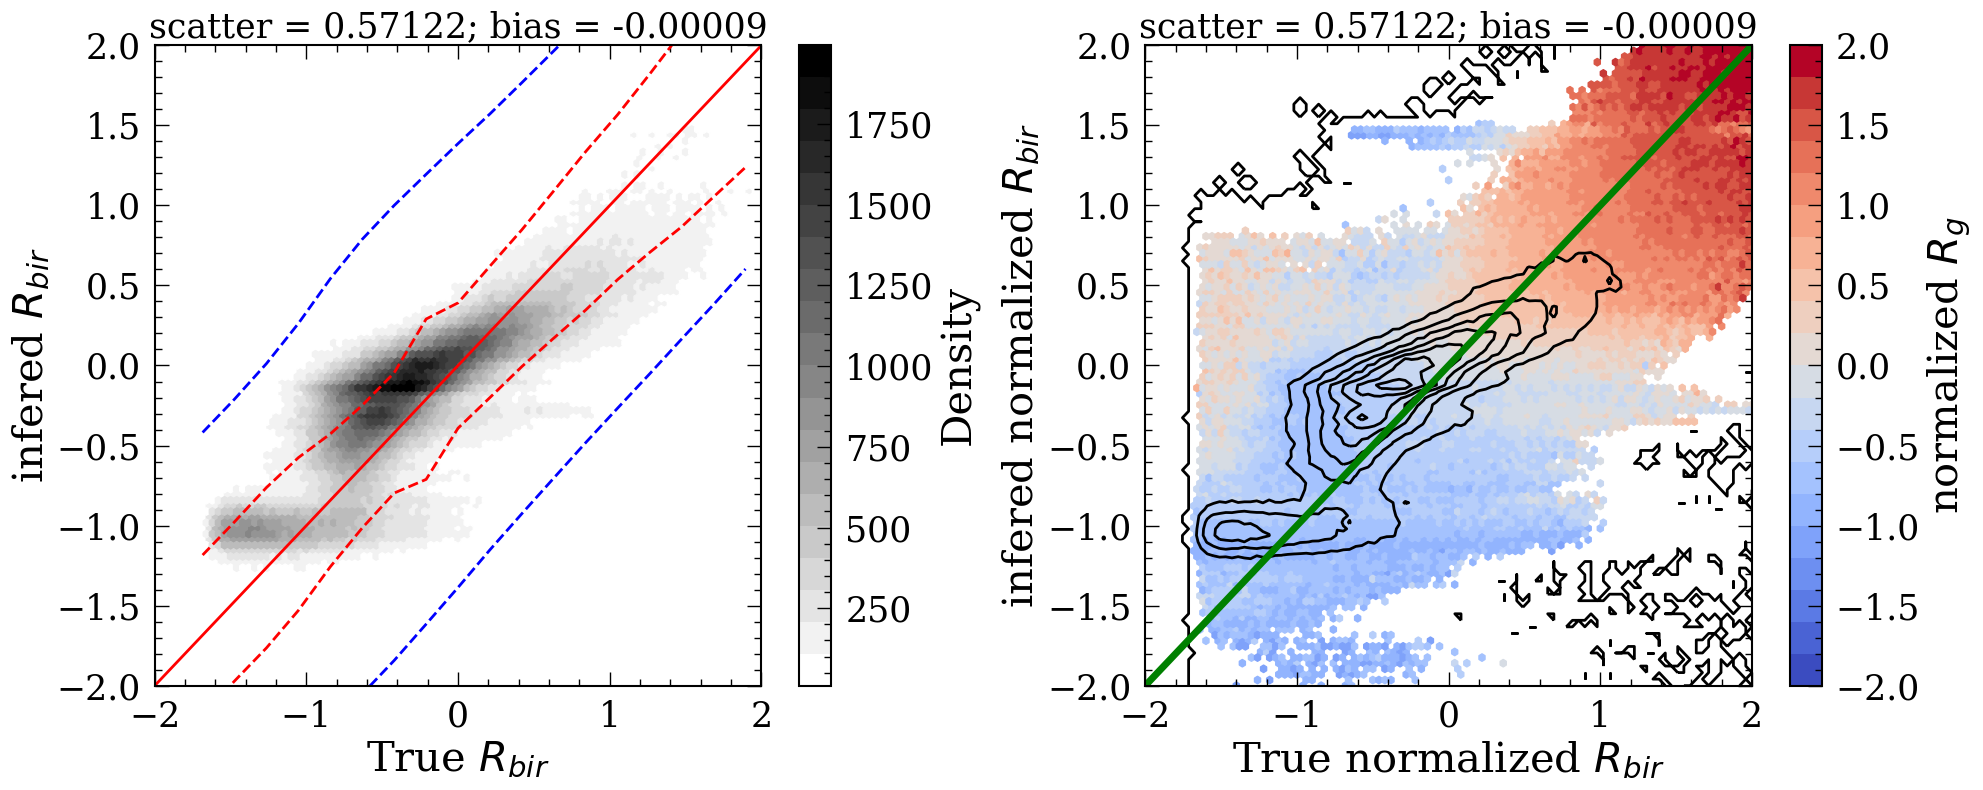

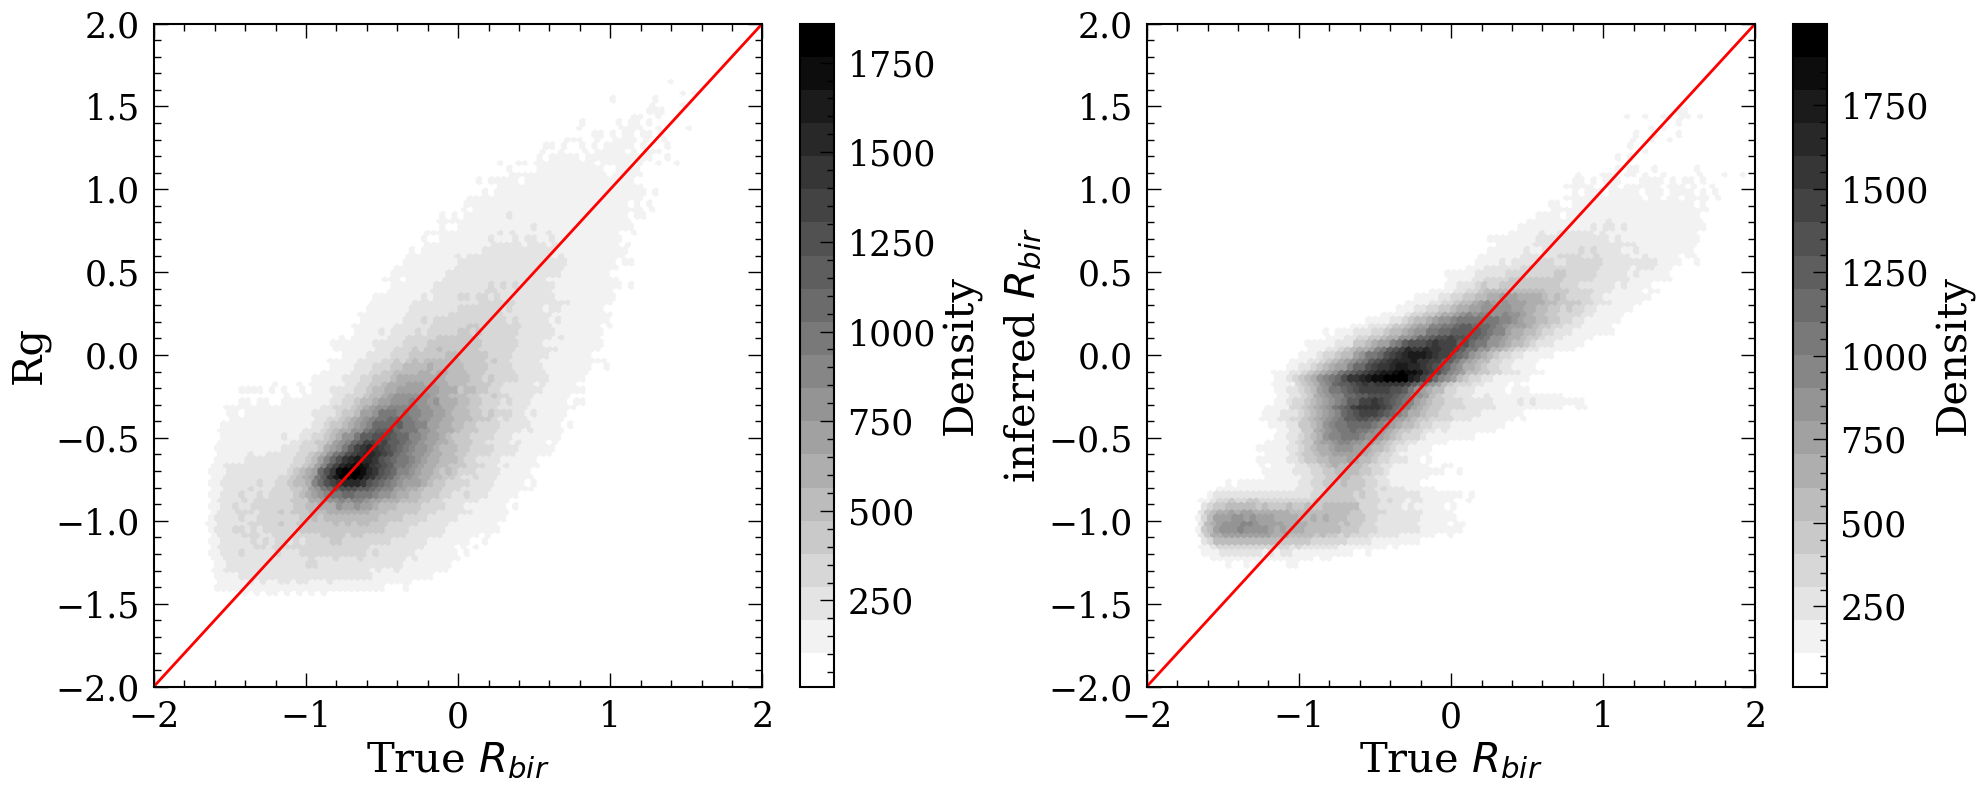

In [179]:
plt.figure(figsize=(19,5))
absweights, weights_imp, weights_imp_err, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.errorbar(range(len(allnames)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
plt.plot(range(len(allnames)),np.zeros(len(allnames)),'r-')
plt.xticks(range(len(allnames)), allnames, rotation=45)
#plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-5,5])
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(-2, 2, 100)


plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))

plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
cmap1 = plt.cm.get_cmap('coolwarm',20)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
plt.hexbin(y, ypred, C = normalize_data(data['Rg'].values), extent = (-2,2,-2,2), gridsize = 100, 
           cmap = cmap1, vmin = -2, vmax = 2, mincnt=10)
plt.plot(xs, xs, "g-", linewidth=5)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True normalized $R_{bir}$")
plt.ylabel("infered normalized $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('normalized $R_g$')
from matplotlib.colors import LogNorm
counts,xbins,ybins=np.histogram2d(y, ypred, bins = (np.linspace(-2,2,100),np.linspace(-2,2,100)))
plt.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),
    ybins.min(),ybins.max()],linewidths=2,colors='black',
    linestyles='solid')
plt.tight_layout()


plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
plt.hexbin(normalize_data(data['Rbir']), normalize_data(data['Rg']), 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("Rg")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
plt.hexbin(y, ypred, 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("inferred $R_{bir}$")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.tight_layout()

  0%|          | 0/6 [00:00<?, ?it/s]

6.96e11
Reading in simulation...
Finished reading in simulation...


 17%|█▋        | 1/6 [00:23<01:55, 23.06s/it]

8.26e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 2/6 [00:50<01:42, 25.66s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [01:21<01:23, 27.98s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 83%|████████▎ | 5/6 [02:25<00:30, 30.21s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6/6 [02:48<00:00, 28.14s/it]


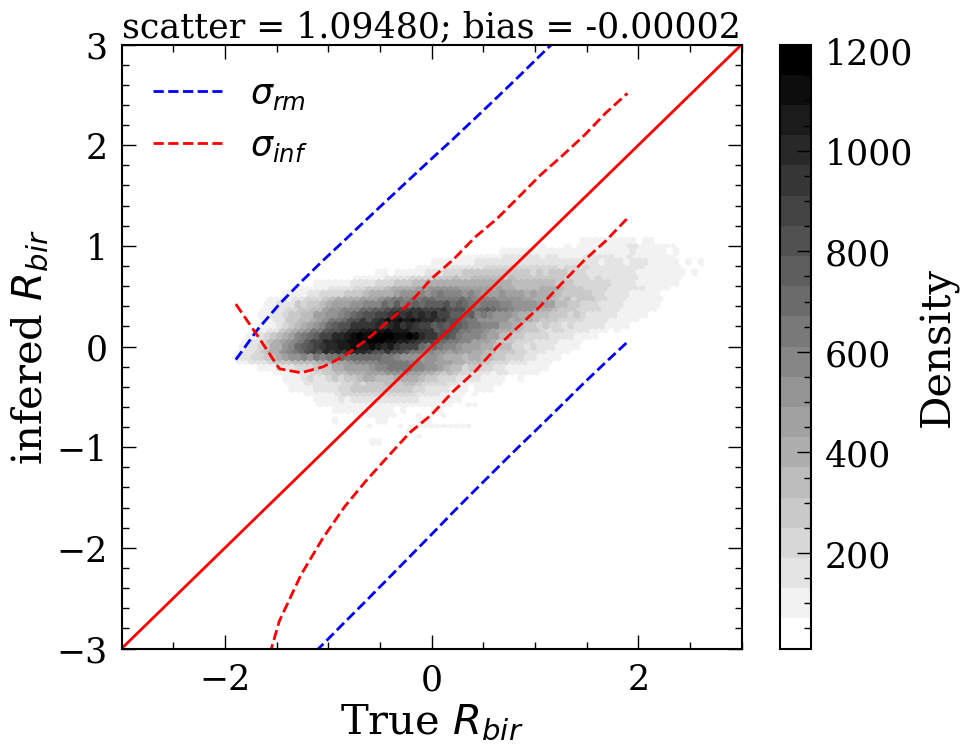

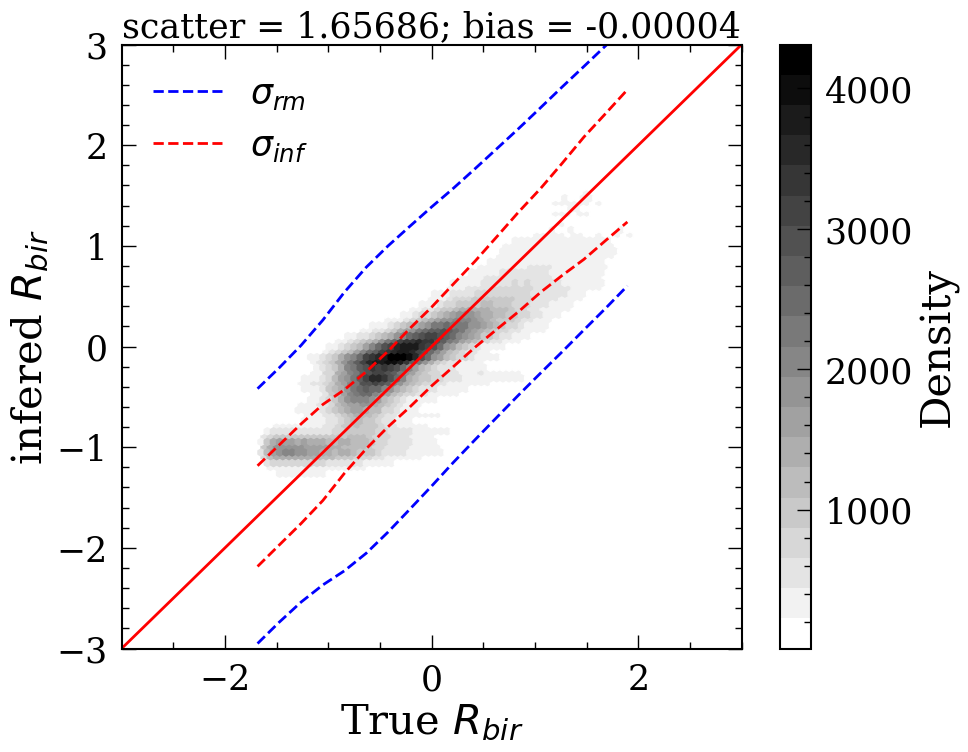

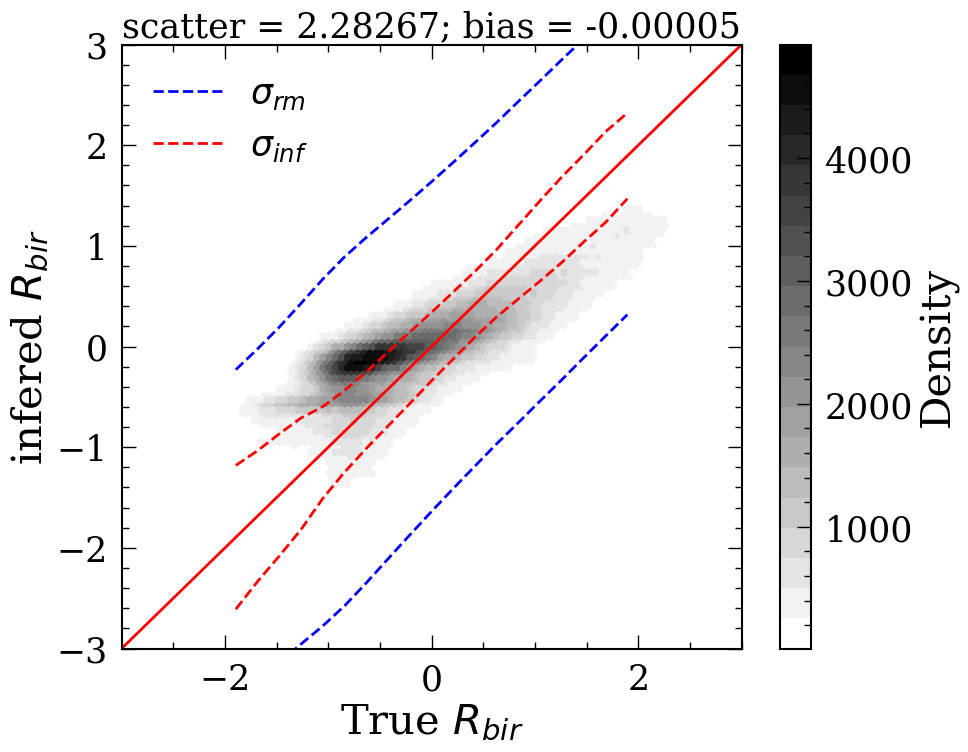

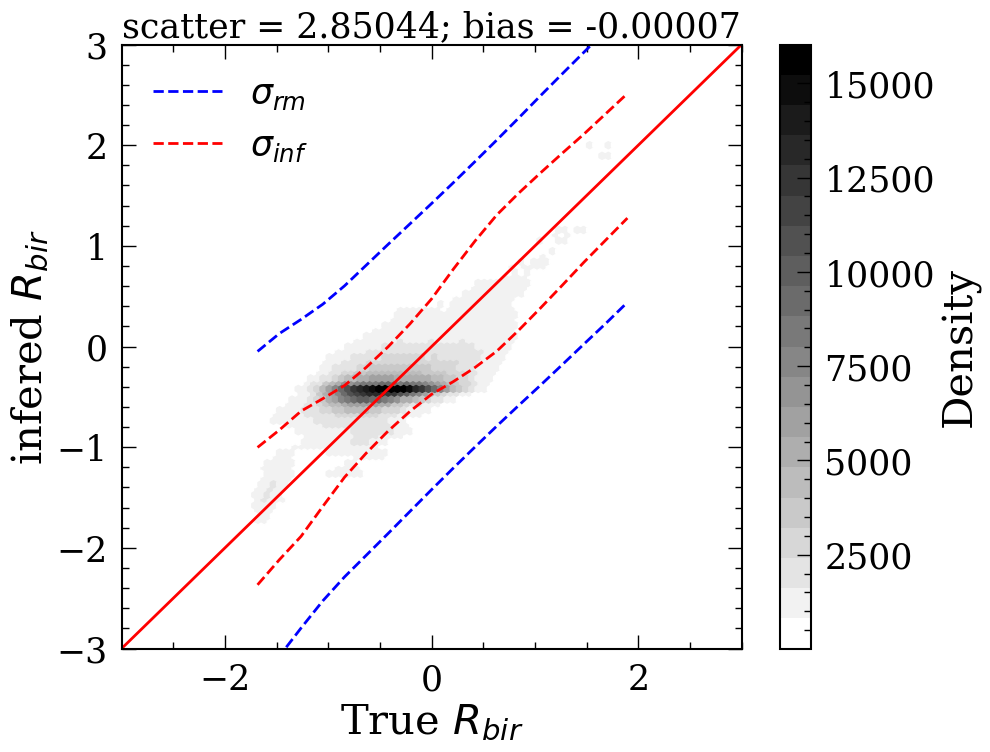

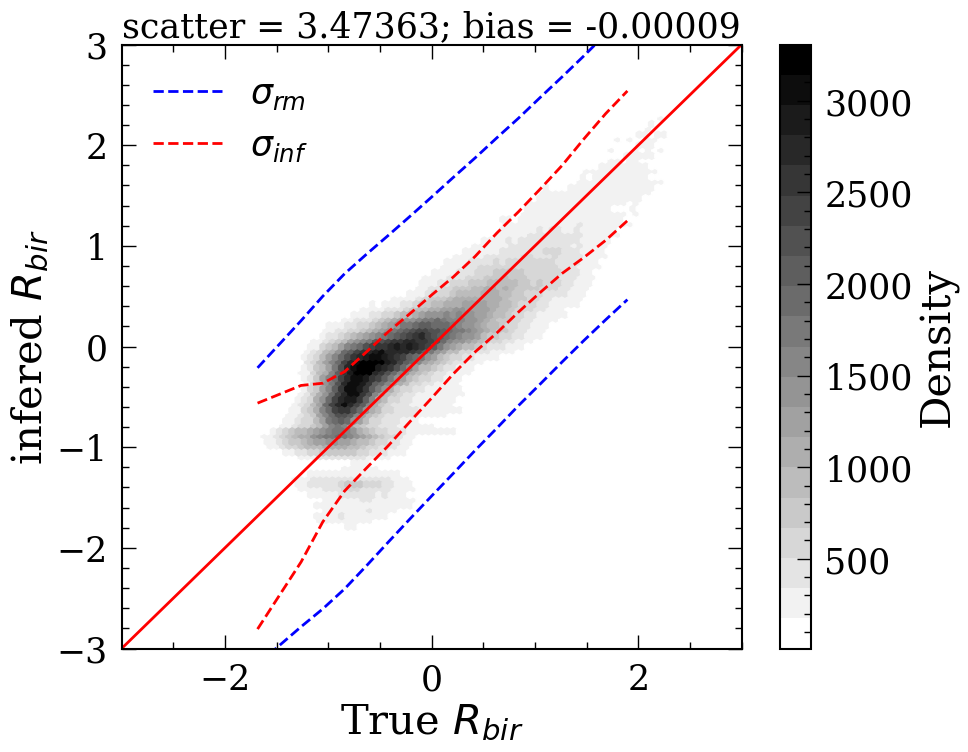

In [180]:
cmap = plt.cm.get_cmap('binary',20)
scatter, bias = 0, 0
for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12' or simsnames[i]==simNo:
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=15
    zcut_thread=5
    
    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')

    y, ypred = predNew(weights, data)
    
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)+scatter
    bias  = np.mean(y-ypred)+bias
    
    plt.hexbin(y, ypred, extent=(-3,3,-3,3),gridsize=100, mincnt=10, cmap=cmap)
    Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
    Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))
    plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
    plt.plot(Rbirs, Rbirs-Rstds, 'b--')
    plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
    plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
    plt.plot([-3, 3], [-3, 3], "r-")
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    plt.legend()
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth_predW_model_disk'+simsnames[0]+'.png')
scatter = scatter/4
bias = bias/4

out826 = pd.DataFrame(np.array((np.append(allnames,['scatter','bias','scatter_pred','bias_pred']), 
                               np.append(weights,[np.std(y-ypred),np.mean(y-ypred),scatter,bias]), 
                               np.append(weights_err,[0, 0, 0, 0]))).T,
                      columns=['names','w826','w_err826'])

Use 7.08e11

In [181]:
i=2
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
print('Finished reading in simulation...')

print('Calculating weights...')
allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
print('Finished calculating weights...')


Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


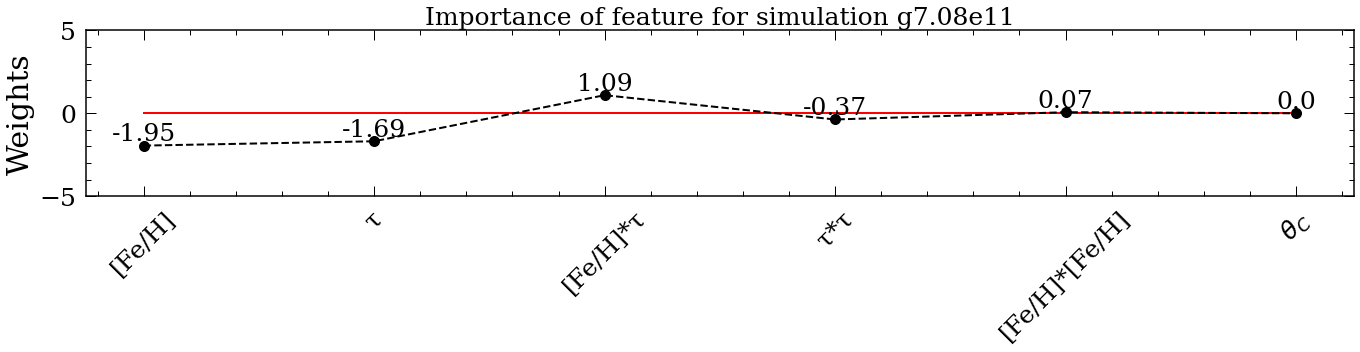

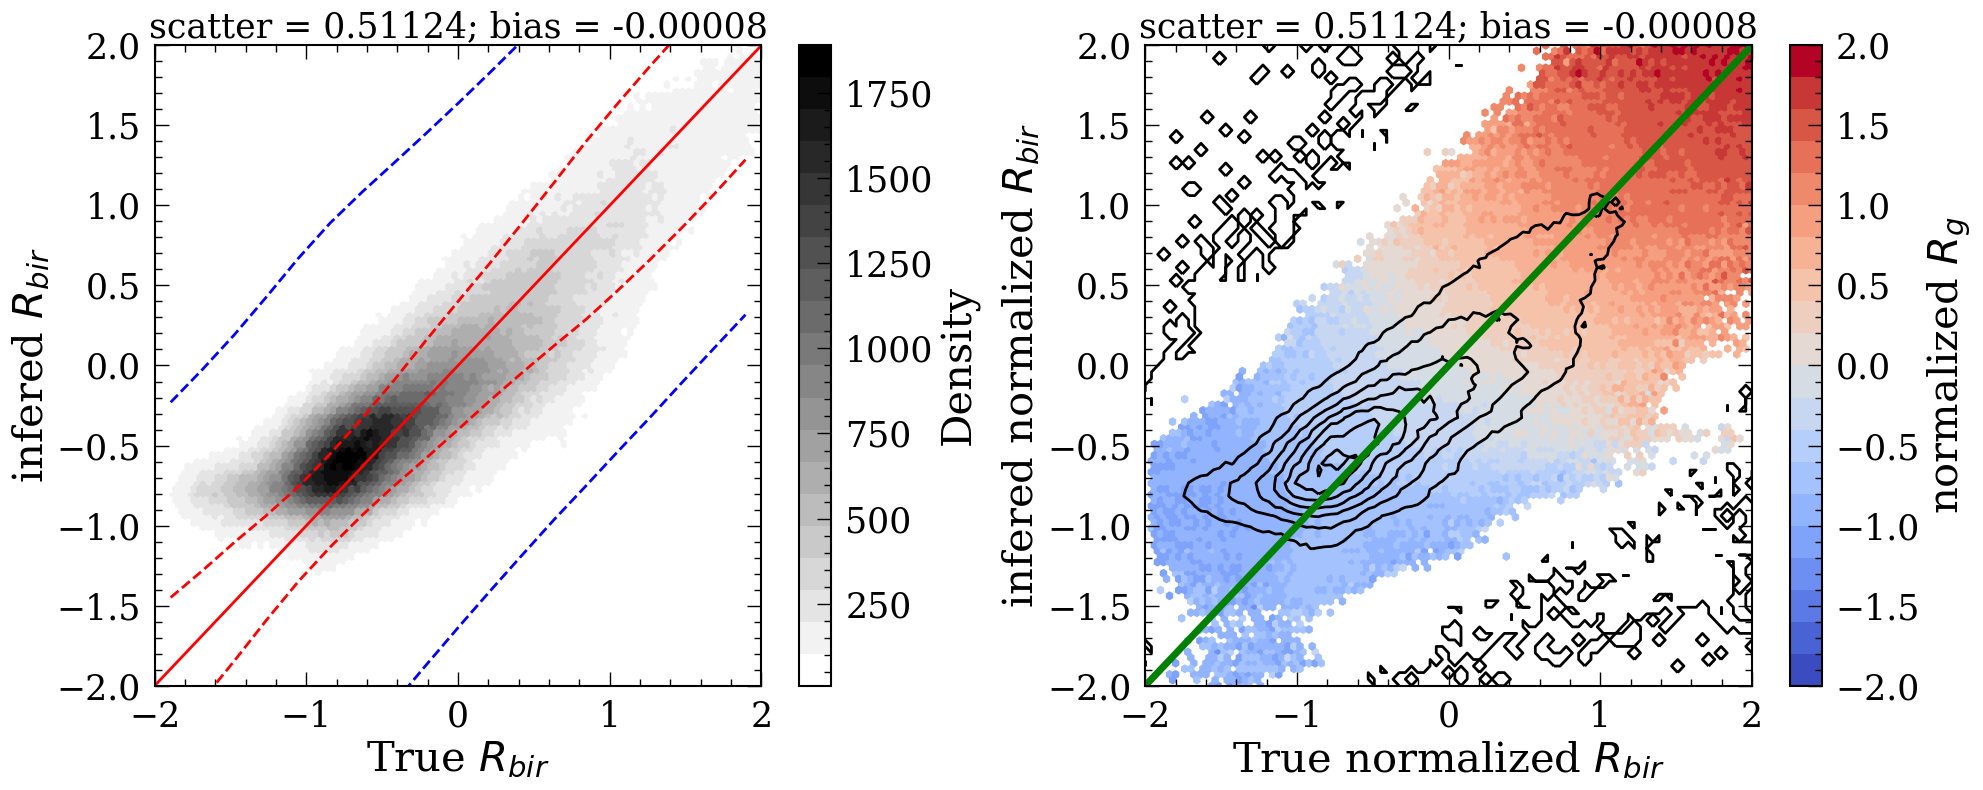

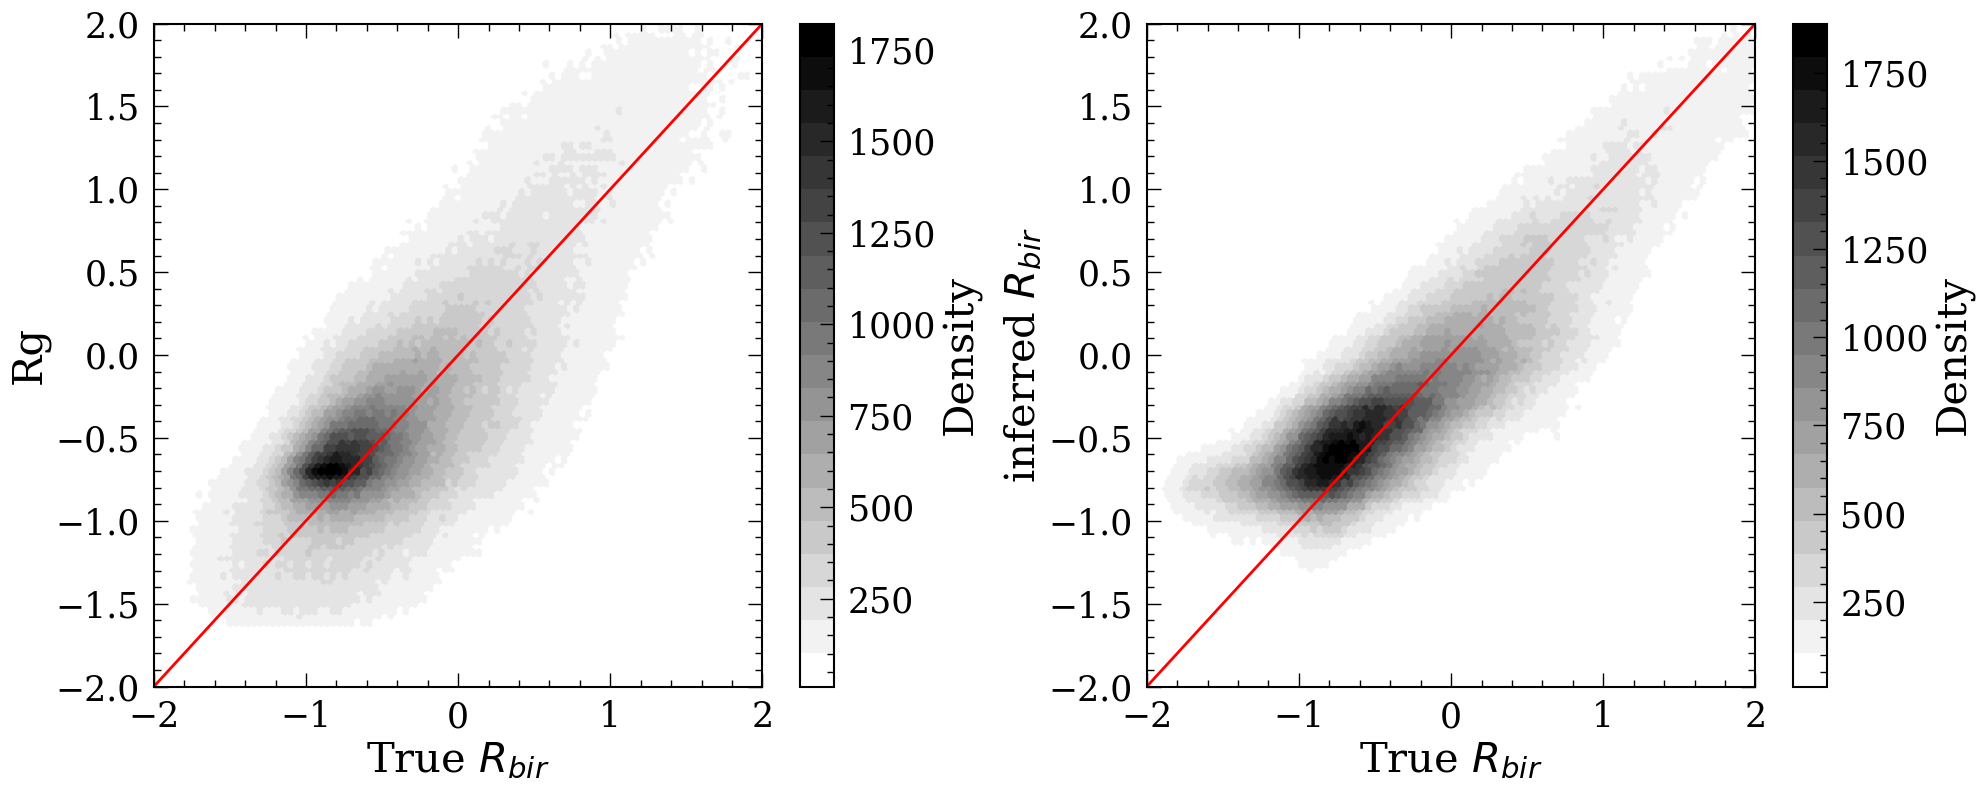

In [182]:
plt.figure(figsize=(19,5))
absweights, weights_imp, weights_imp_err, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.errorbar(range(len(allnames)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
plt.plot(range(len(allnames)),np.zeros(len(allnames)),'r-')
plt.xticks(range(len(allnames)), allnames, rotation=45)
#plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-5,5])
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(-2, 2, 100)


plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))

plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
cmap1 = plt.cm.get_cmap('coolwarm',20)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
plt.hexbin(y, ypred, C = normalize_data(data['Rg'].values), extent = (-2,2,-2,2), gridsize = 100, 
           cmap = cmap1, vmin = -2, vmax = 2, mincnt=10)
plt.plot(xs, xs, "g-", linewidth=5)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True normalized $R_{bir}$")
plt.ylabel("infered normalized $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('normalized $R_g$')
from matplotlib.colors import LogNorm
counts,xbins,ybins=np.histogram2d(y, ypred, bins = (np.linspace(-2,2,100),np.linspace(-2,2,100)))
plt.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),
    ybins.min(),ybins.max()],linewidths=2,colors='black',
    linestyles='solid')
plt.tight_layout()

plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
plt.hexbin(normalize_data(data['Rbir']), normalize_data(data['Rg']), 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("Rg")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
plt.hexbin(y, ypred, 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("inferred $R_{bir}$")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.tight_layout()

  0%|          | 0/6 [00:00<?, ?it/s]

6.96e11
Reading in simulation...
Finished reading in simulation...


 17%|█▋        | 1/6 [00:16<01:20, 16.19s/it]

8.26e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 2/6 [00:43<01:31, 22.84s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [01:08<01:11, 23.72s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 83%|████████▎ | 5/6 [02:15<00:29, 29.19s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6/6 [02:51<00:00, 28.66s/it]


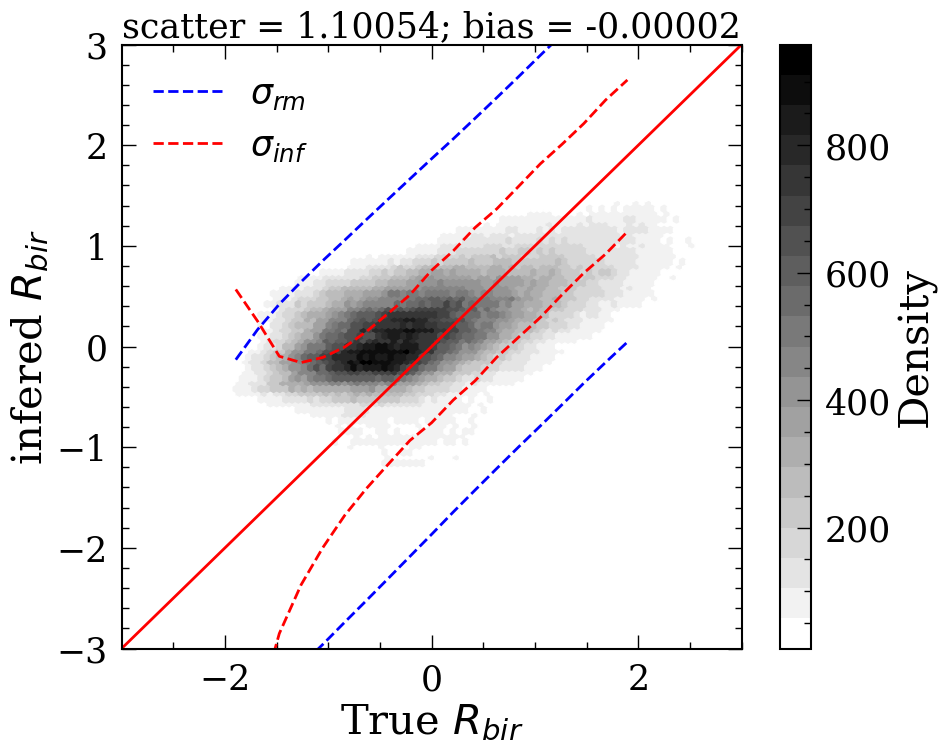

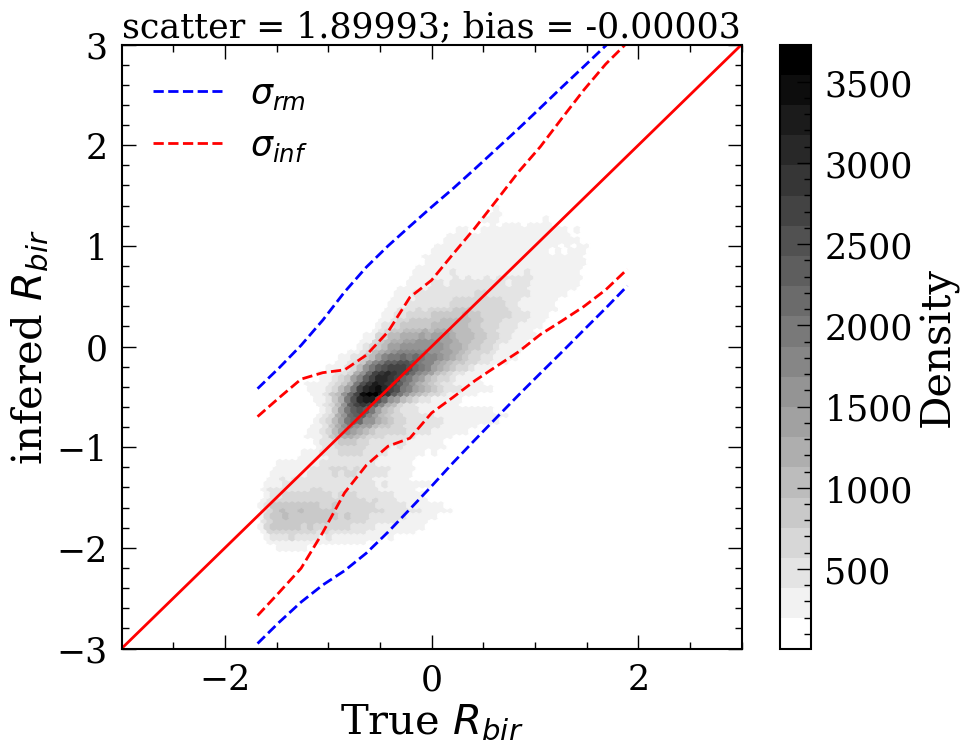

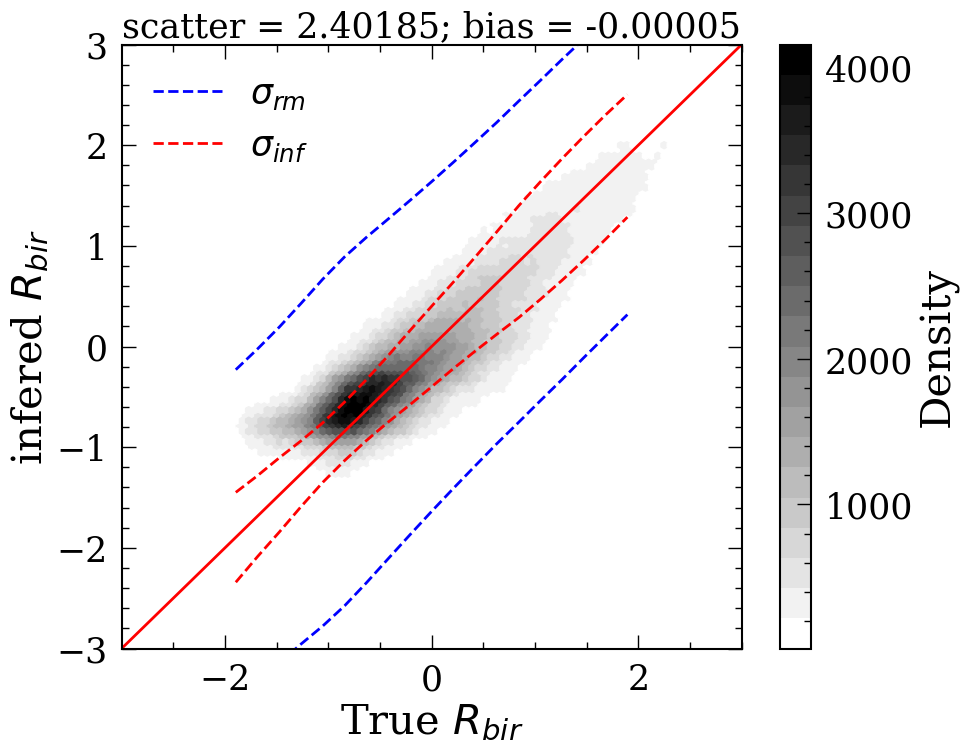

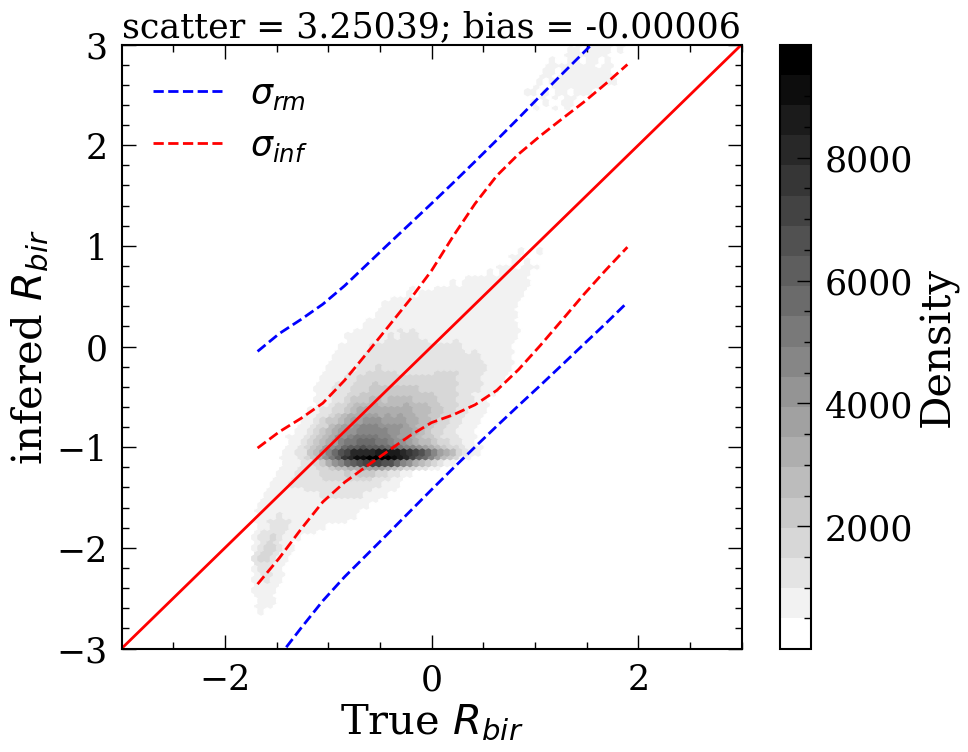

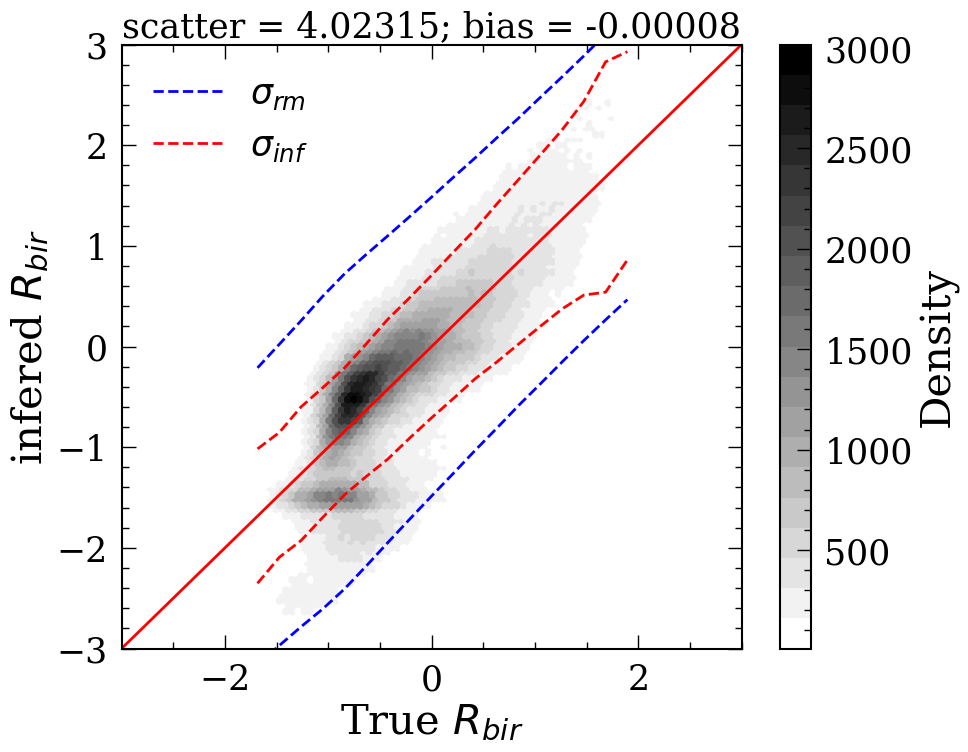

In [183]:
cmap = plt.cm.get_cmap('binary',20)
scatter, bias = 0, 0
for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12' or simsnames[i]==simNo:
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=15
    zcut_thread=5
    
    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')

    y, ypred = predNew(weights, data)
    
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)+scatter
    bias  = np.mean(y-ypred)+bias
    
    plt.hexbin(y, ypred, extent=(-3,3,-3,3),gridsize=100, mincnt=10, cmap=cmap)
    Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
    Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))
    plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
    plt.plot(Rbirs, Rbirs-Rstds, 'b--')
    plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
    plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
    plt.plot([-3, 3], [-3, 3], "r-")
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    plt.legend()
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth_predW_model_disk'+simsnames[0]+'.png')
scatter = scatter/4
bias = bias/4

out708 = pd.DataFrame(np.array((np.append(allnames,['scatter','bias','scatter_pred','bias_pred']), 
                               np.append(weights,[np.std(y-ypred),np.mean(y-ypred),scatter,bias]), 
                               np.append(weights_err,[0, 0, 0, 0]))).T,
                      columns=['names','w708','w_err708'])

Use 2.79e12

In [ ]:
i=-2
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
print('Finished reading in simulation...')

print('Calculating weights...')
data = data.dropna(subset=['Rg','feh'])
allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
print('Finished calculating weights...')


Reading in simulation...


In [ ]:
plt.figure(figsize=(19,5))
absweights, weights_imp, weights_imp_err, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.errorbar(range(len(allnames)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
plt.plot(range(len(allnames)),np.zeros(len(allnames)),'r-')
plt.xticks(range(len(allnames)), allnames, rotation=45)
#plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-5,5])
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(-2, 2, 100)


plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))

plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
cmap1 = plt.cm.get_cmap('coolwarm',20)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
plt.hexbin(y, ypred, C = normalize_data(data['Rg'].values), extent = (-2,2,-2,2), gridsize = 100, 
           cmap = cmap1, vmin = -2, vmax = 2, mincnt=10)
plt.plot(xs, xs, "g-", linewidth=5)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True normalized $R_{bir}$")
plt.ylabel("infered normalized $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('normalized $R_g$')
from matplotlib.colors import LogNorm
counts,xbins,ybins=np.histogram2d(y, ypred, bins = (np.linspace(-2,2,100),np.linspace(-2,2,100)))
plt.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),
    ybins.min(),ybins.max()],linewidths=2,colors='black',
    linestyles='solid')
plt.tight_layout()


plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
plt.hexbin(normalize_data(data['Rbir']), normalize_data(data['Rg']), 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("Rg")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
plt.hexbin(y, ypred, 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("inferred $R_{bir}$")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.tight_layout()

  0%|          | 0/6 [00:00<?, ?it/s]

6.96e11
Reading in simulation...
Finished reading in simulation...


 17%|█▋        | 1/6 [00:35<02:55, 35.14s/it]

8.26e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 2/6 [01:38<03:26, 51.62s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [02:40<02:49, 56.58s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 83%|████████▎ | 5/6 [04:03<00:47, 47.97s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6/6 [04:32<00:00, 45.43s/it]


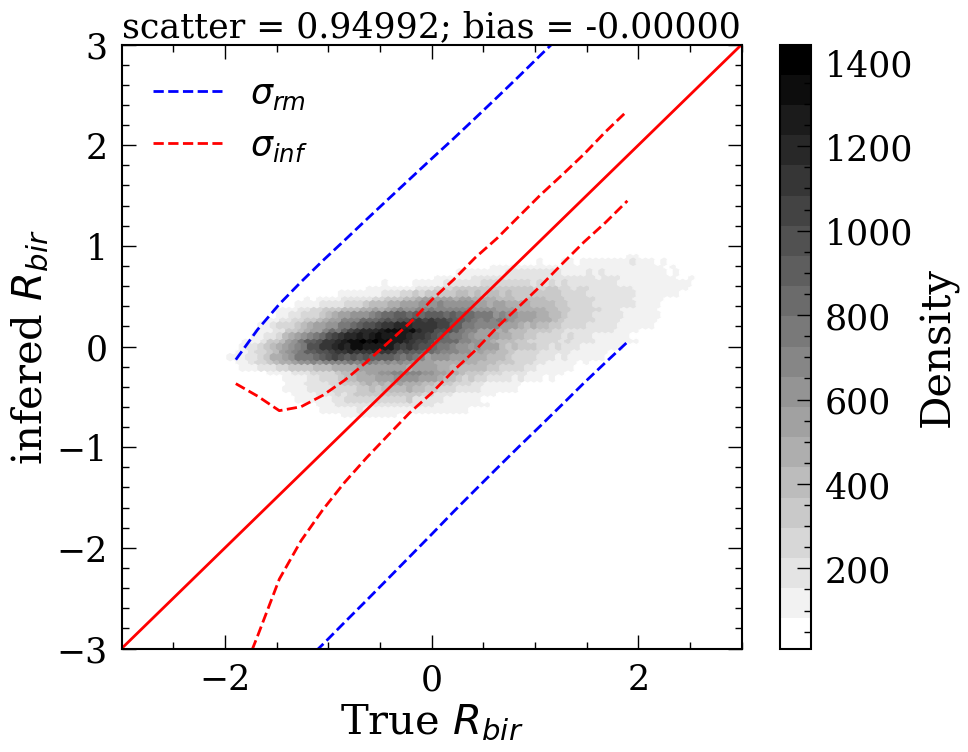

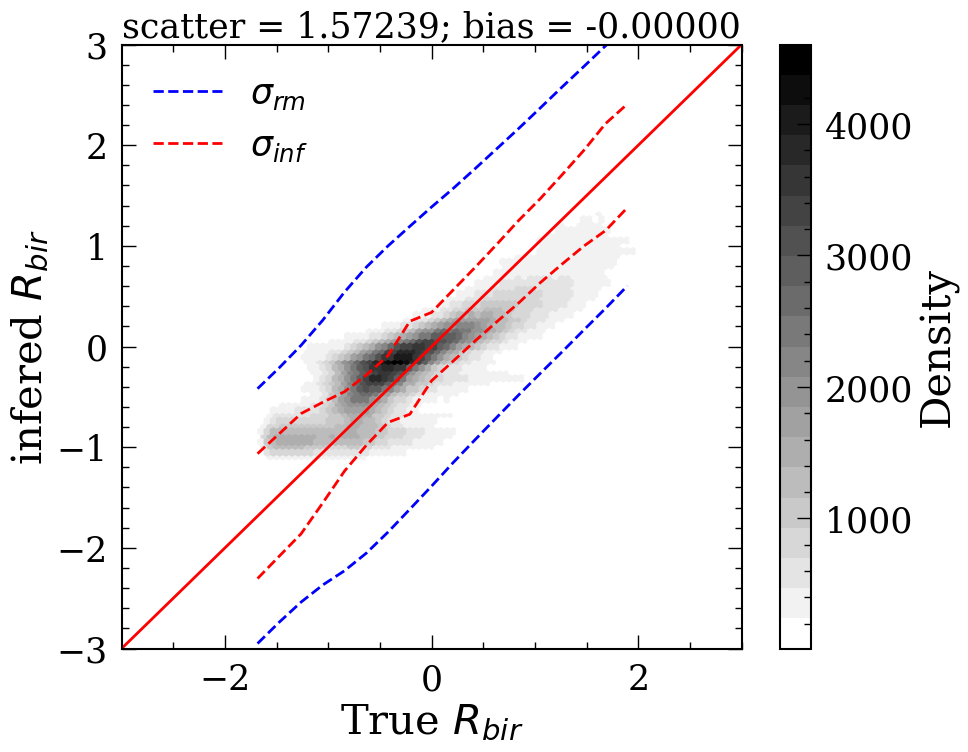

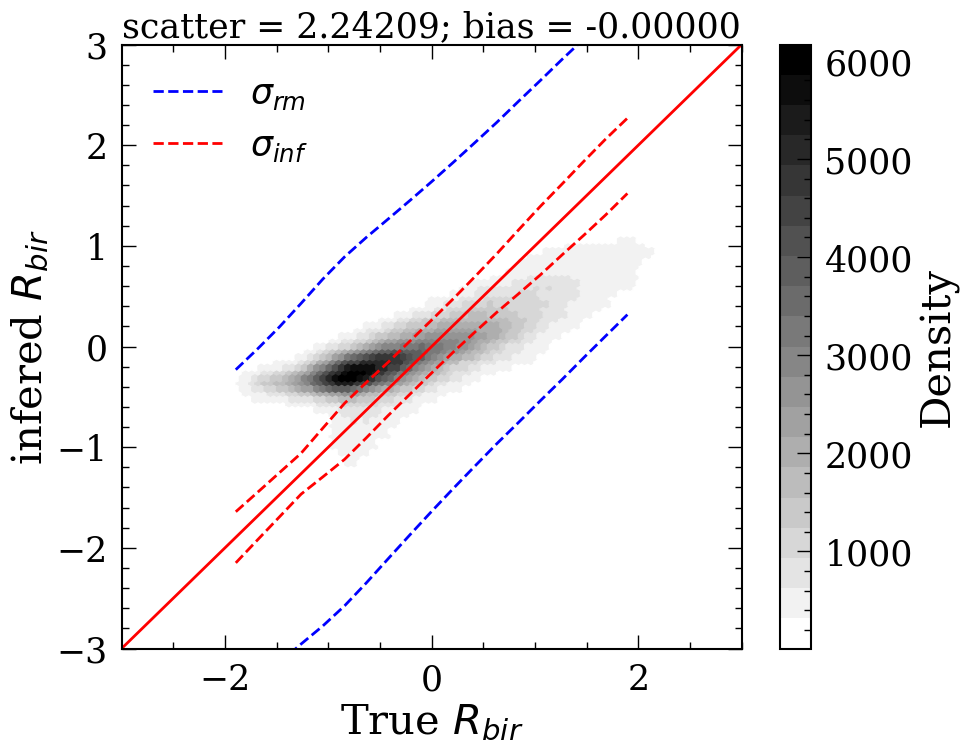

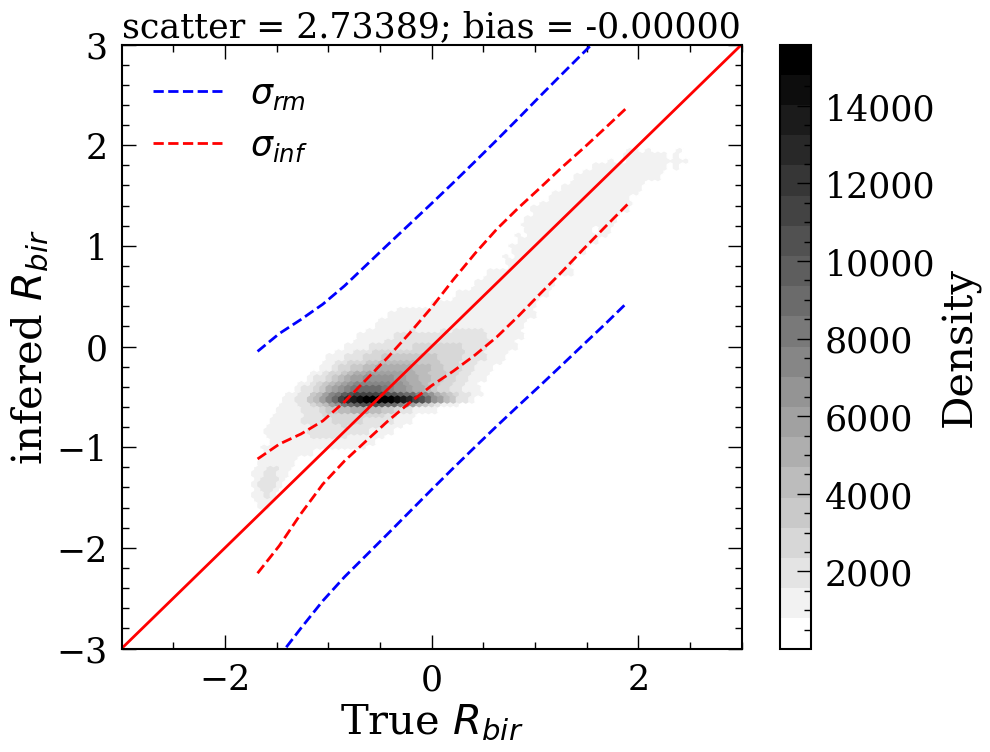

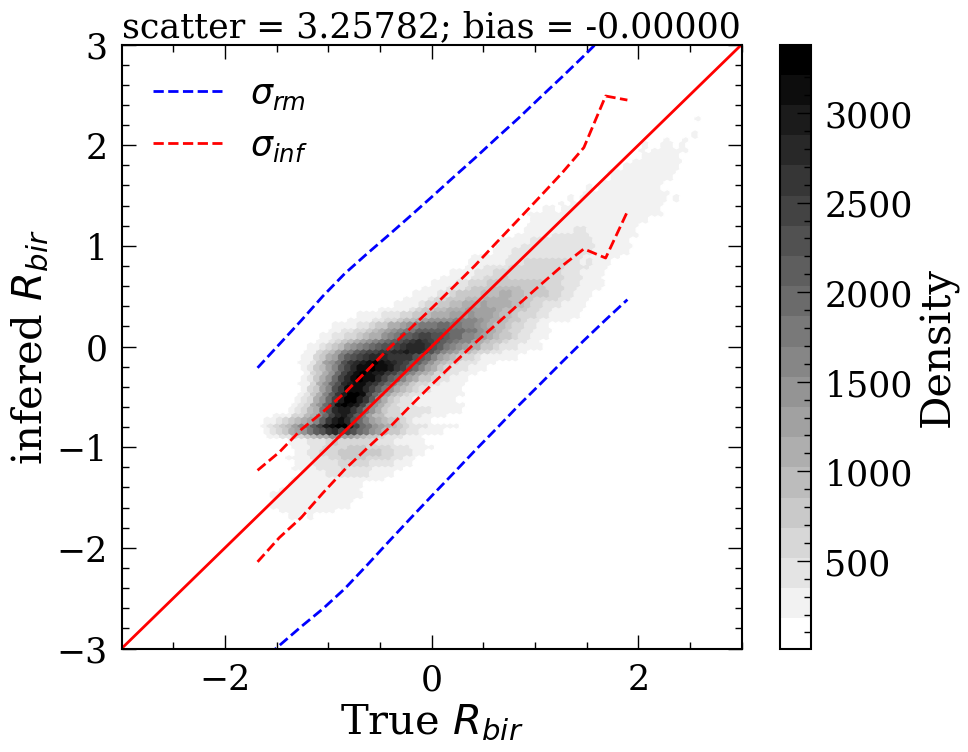

In [186]:
cmap = plt.cm.get_cmap('binary',20)
scatter, bias = 0, 0
for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12' or simsnames[i]==simNo:
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=15
    zcut_thread=5
    
    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')

    y, ypred = predNew(weights, data)
    
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)+scatter
    bias  = np.mean(y-ypred)+bias
    
    plt.hexbin(y, ypred, extent=(-3,3,-3,3),gridsize=100, mincnt=10, cmap=cmap)
    Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
    Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))
    plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
    plt.plot(Rbirs, Rbirs-Rstds, 'b--')
    plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
    plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
    plt.plot([-3, 3], [-3, 3], "r-")
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    plt.legend()
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth_predW_model_disk'+simsnames[0]+'.png')
scatter = scatter/4
bias = bias/4

out279 = pd.DataFrame(np.array((np.append(allnames,['scatter','bias','scatter_pred','bias_pred']), 
                               np.append(weights,[np.std(y-ypred),np.mean(y-ypred),scatter,bias]), 
                               np.append(weights_err,[0, 0, 0, 0]))).T,
                      columns=['names','w279','w_err279'])

Use 7.55e11

In [187]:
i=-1
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
print('Finished reading in simulation...')

print('Calculating weights...')
allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
print('Finished calculating weights...')


Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


In [188]:
"""
allsnaps = glob.glob(sims[i]+'/*.?????')
    
allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}
snap = snaplookup[max(allsnaps_time)]

print(snap)
s = pb.load(snap)
h=s.halos()
pb.analysis.angmom.faceon(h[1])
s.physical_units()
p = pb.analysis.profile.Profile(h[1],rmin=.01,rmax =250,type='log',ndim=3)
pg = pb.analysis.profile.Profile(h[1].g,rmin=.01,rmax =250,type='log',ndim=3)
ps = pb.analysis.profile.Profile(h[1].s,rmin=.01,rmax =250,type='log',ndim=3)
pd = pb.analysis.profile.Profile(h[1].d,rmin=.01,rmax =250,type='log',ndim=3)


f = interp1d(p['rbins'], p['v_circ'])
vphis = np.zeros(len(data))*np.nan
vphis[data['R'].values>=min(p['rbins'])] = f(data['R'].values[data['R'].values>=min(p['rbins'])])
data['vc'] = vphis

data['Rg']=data['vcxy']*data['R']/data['vc']


data.to_pickle('./g'+simNo+'_z_0_decomp.pkl')


"""

"\nallsnaps = glob.glob(sims[i]+'/*.?????')\n    \nallsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]\nsnaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}\nsnap = snaplookup[max(allsnaps_time)]\n\nprint(snap)\ns = pb.load(snap)\nh=s.halos()\npb.analysis.angmom.faceon(h[1])\ns.physical_units()\np = pb.analysis.profile.Profile(h[1],rmin=.01,rmax =250,type='log',ndim=3)\npg = pb.analysis.profile.Profile(h[1].g,rmin=.01,rmax =250,type='log',ndim=3)\nps = pb.analysis.profile.Profile(h[1].s,rmin=.01,rmax =250,type='log',ndim=3)\npd = pb.analysis.profile.Profile(h[1].d,rmin=.01,rmax =250,type='log',ndim=3)\n\n\nf = interp1d(p['rbins'], p['v_circ'])\nvphis = np.zeros(len(data))*np.nan\nvphis[data['R']

/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


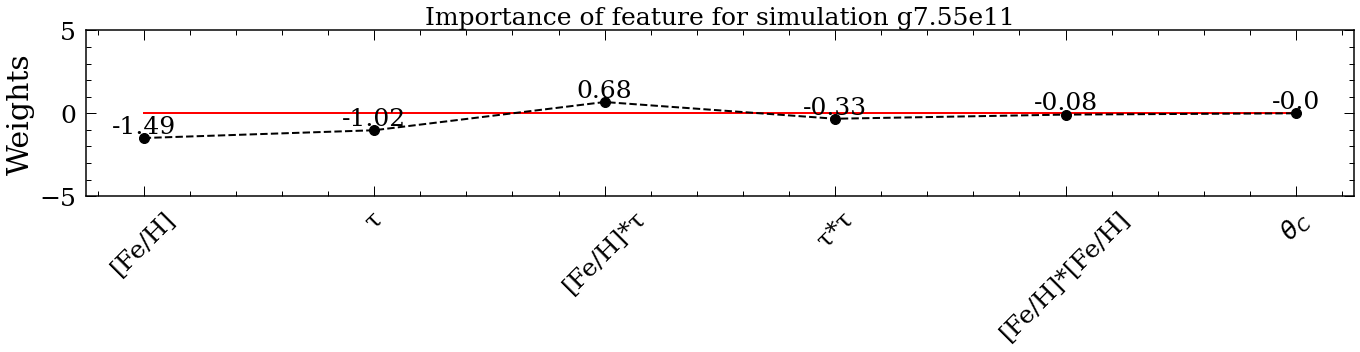

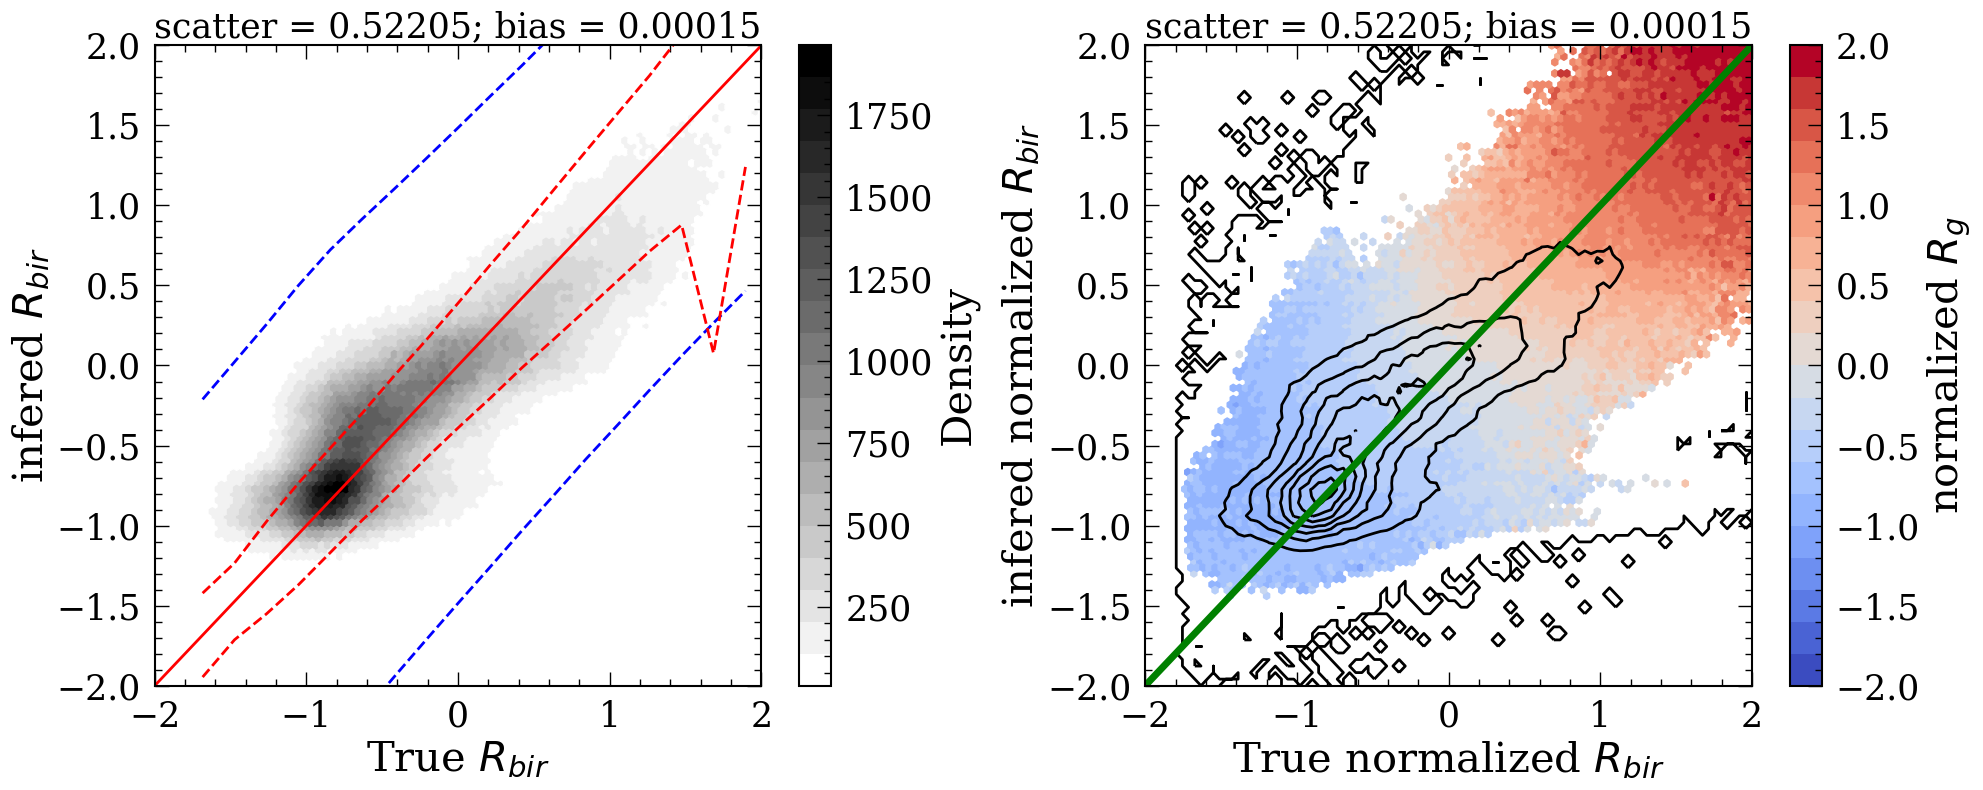

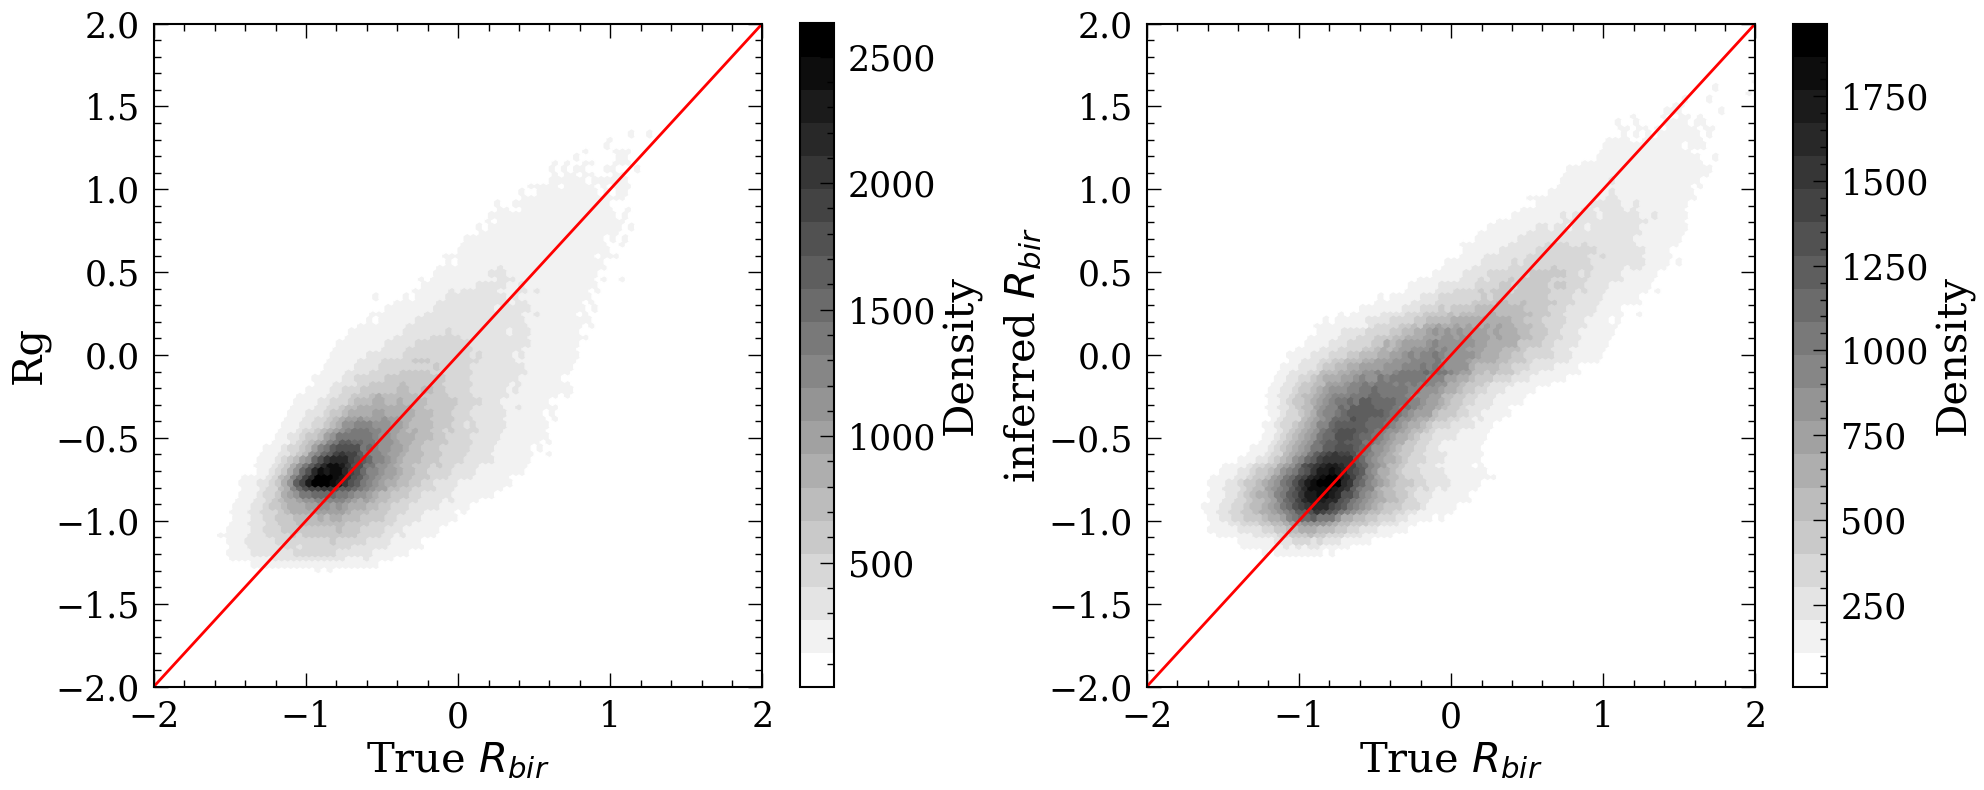

In [189]:
plt.figure(figsize=(19,5))
absweights, weights_imp, weights_imp_err, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.errorbar(range(len(allnames)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
plt.plot(range(len(allnames)),np.zeros(len(allnames)),'r-')
plt.xticks(range(len(allnames)), allnames, rotation=45)
#plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-5,5])
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(-2, 2, 100)


plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))

plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
cmap1 = plt.cm.get_cmap('coolwarm',20)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
plt.hexbin(y, ypred, C = normalize_data(data['Rg'].values), extent = (-2,2,-2,2), gridsize = 100, 
           cmap = cmap1, vmin = -2, vmax = 2, mincnt=10)
plt.plot(xs, xs, "g-", linewidth=5)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True normalized $R_{bir}$")
plt.ylabel("infered normalized $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('normalized $R_g$')
from matplotlib.colors import LogNorm
counts,xbins,ybins=np.histogram2d(y, ypred, bins = (np.linspace(-2,2,100),np.linspace(-2,2,100)))
plt.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),
    ybins.min(),ybins.max()],linewidths=2,colors='black',
    linestyles='solid')
plt.tight_layout()

plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
plt.hexbin(normalize_data(data['Rbir']), normalize_data(data['Rg']), 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("Rg")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
plt.hexbin(y, ypred, 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("inferred $R_{bir}$")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.tight_layout()

  0%|          | 0/6 [00:00<?, ?it/s]

6.96e11
Reading in simulation...
Finished reading in simulation...


 17%|█▋        | 1/6 [00:06<00:33,  6.70s/it]

8.26e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 2/6 [00:31<01:09, 17.29s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [00:46<00:48, 16.29s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 83%|████████▎ | 5/6 [01:46<00:24, 24.06s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6/6 [02:31<00:00, 25.20s/it]


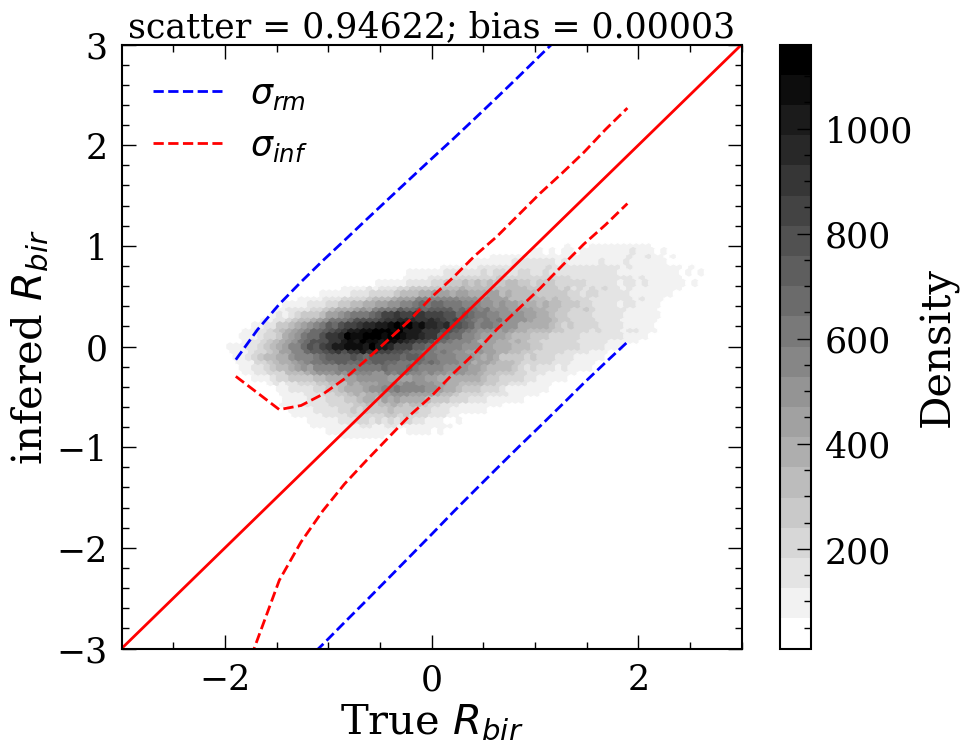

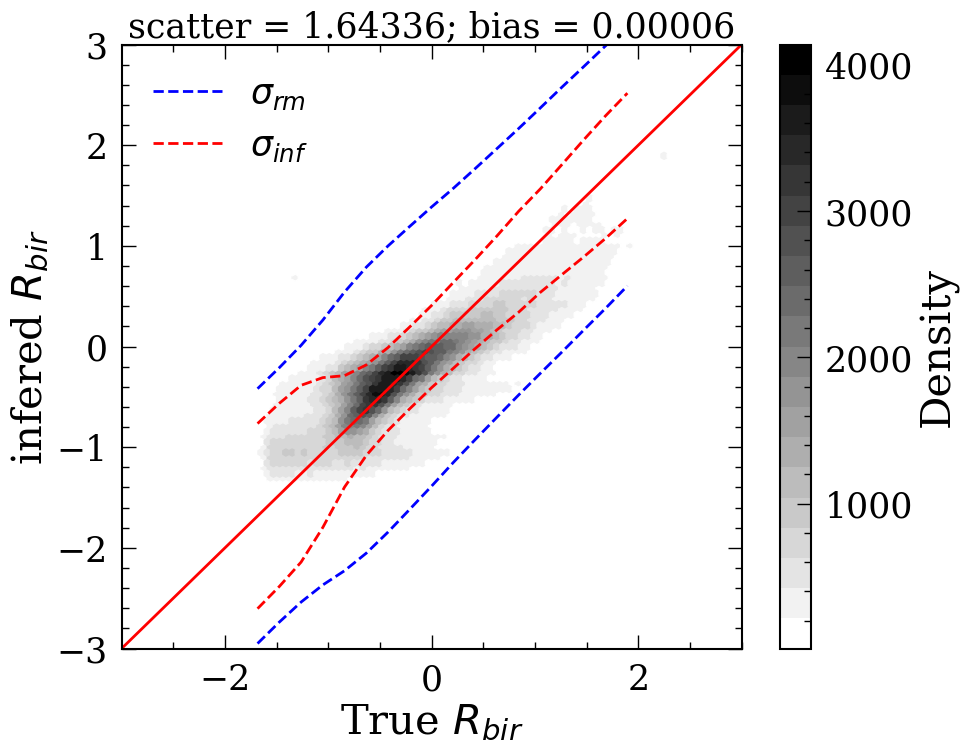

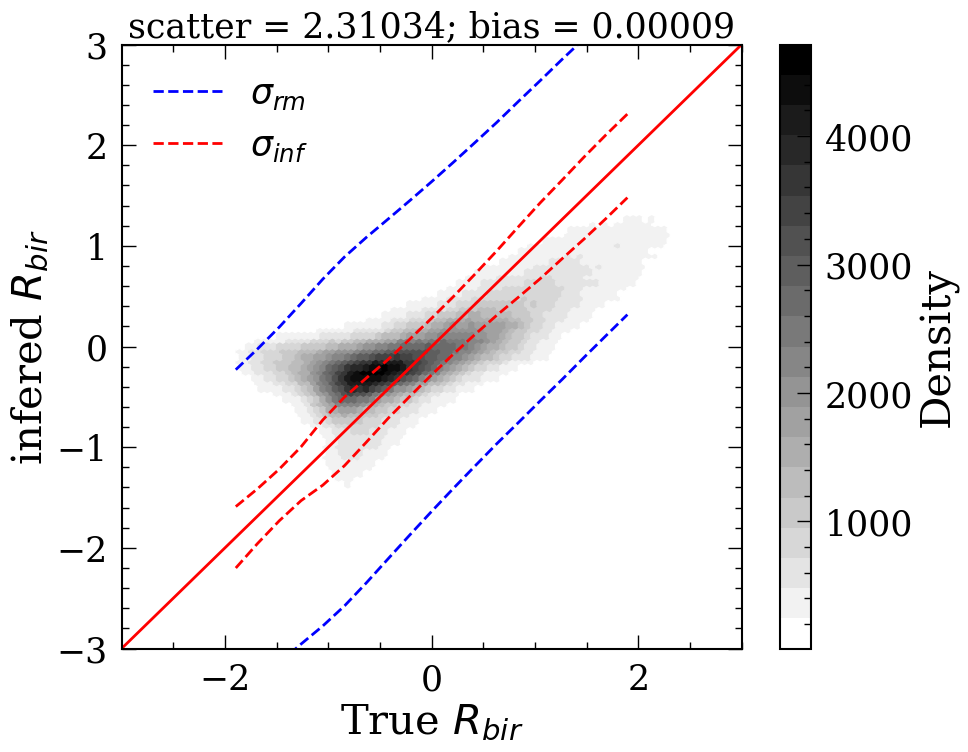

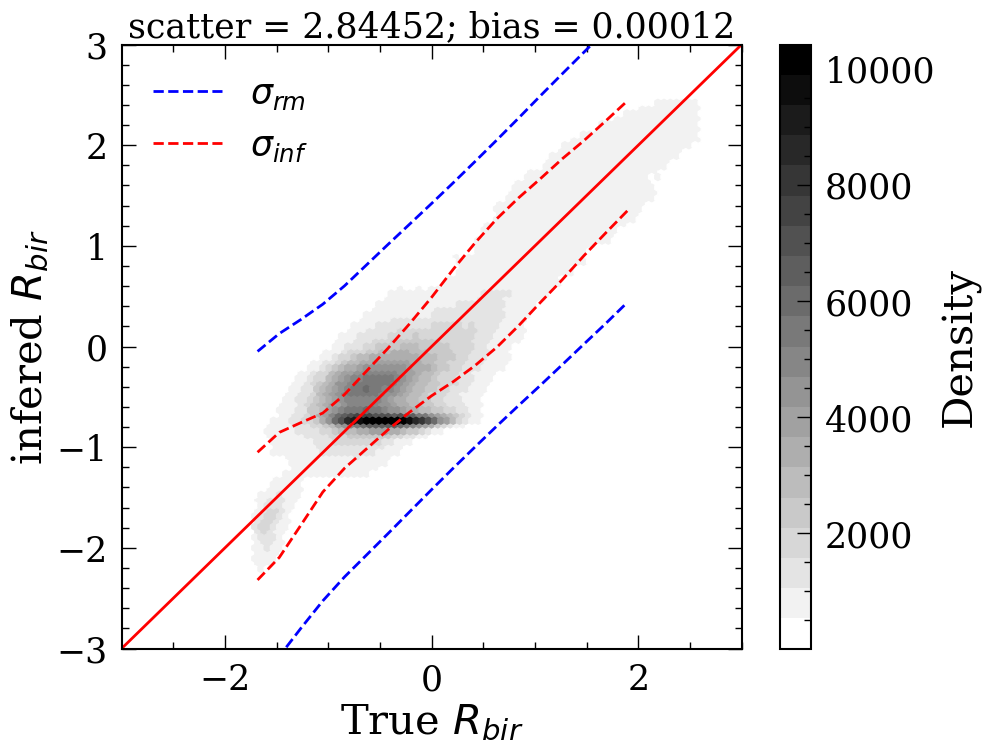

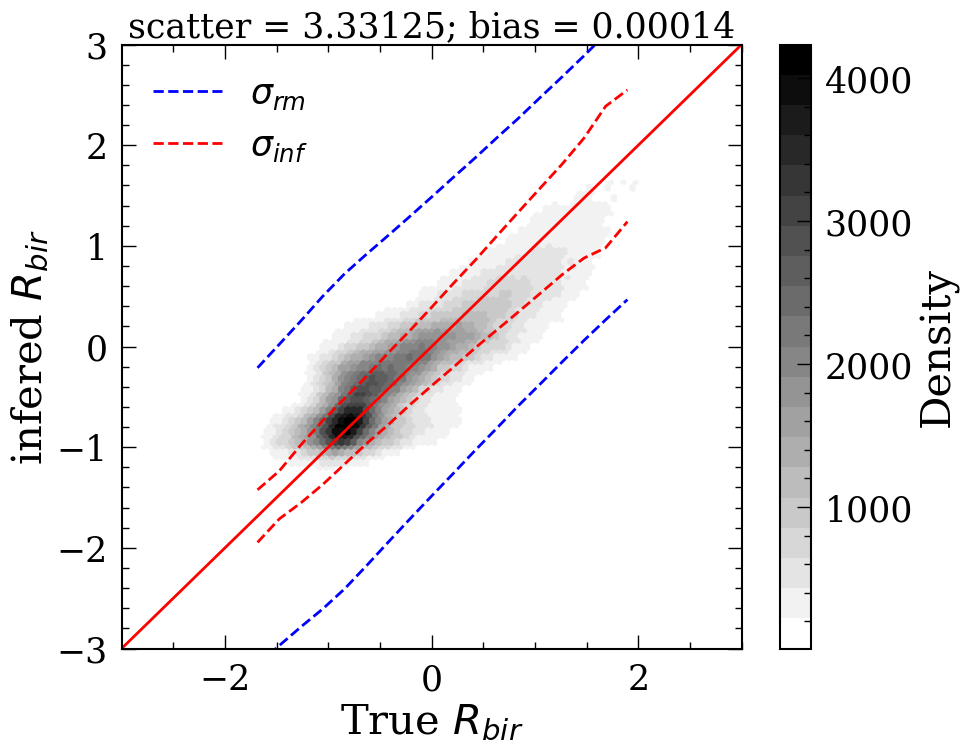

In [190]:
cmap = plt.cm.get_cmap('binary',20)
scatter, bias = 0, 0
for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12' or simsnames[i]==simNo:
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=15
    zcut_thread=5
    
    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')

    y, ypred = predNew(weights, data)
    
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)+scatter
    bias  = np.mean(y-ypred)+bias
    
    plt.hexbin(y, ypred, extent=(-3,3,-3,3),gridsize=100, mincnt=10, cmap=cmap)
    Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
    Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))
    plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
    plt.plot(Rbirs, Rbirs-Rstds, 'b--')
    plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
    plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
    plt.plot([-3, 3], [-3, 3], "r-")
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    plt.legend()
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth_predW_model_disk'+simsnames[0]+'.png')
scatter = scatter/4
bias = bias/4

out755 = pd.DataFrame(np.array((np.append(allnames,['scatter','bias','scatter_pred','bias_pred']), 
                               np.append(weights,[np.std(y-ypred),np.mean(y-ypred),scatter,bias]), 
                               np.append(weights_err,[0, 0, 0, 0]))).T,
                      columns=['names','w755','w_err755'])

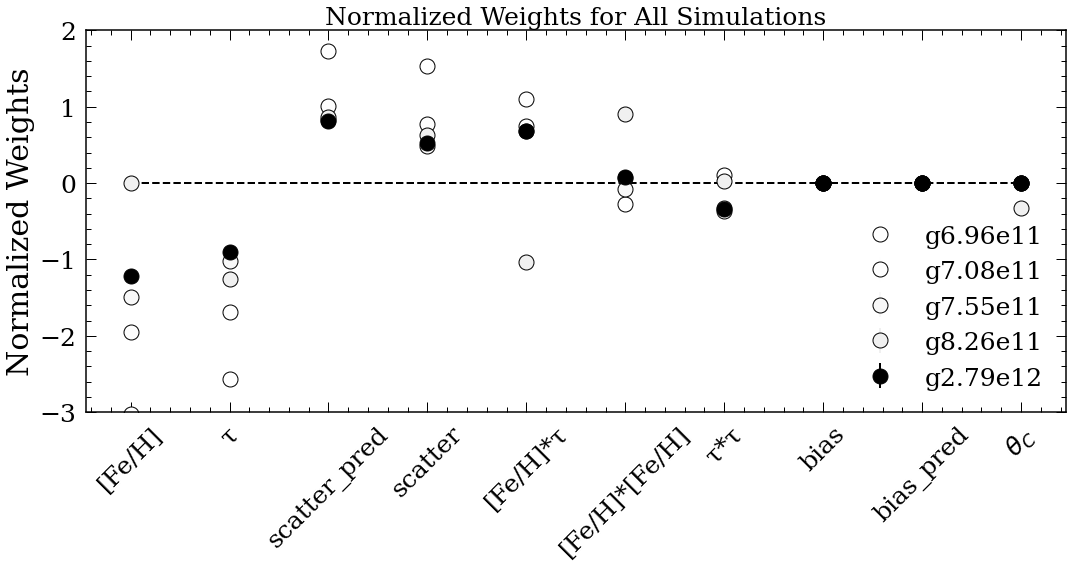

In [172]:
import matplotlib
def getcolor(vrange,cm=plt.cm.get_cmap('binary')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    return [cmap(norm(i)) for i in vrange]
bulgemass = sorted(np.array(simsnames, dtype=float))
colors = getcolor(bulgemass)

outall = pd.merge(out755, out708, left_on='names', right_on='names', how='inner')
outall = pd.merge(outall, out826, left_on='names', right_on='names', how='inner')
outall = pd.merge(outall, out279, left_on='names', right_on='names', how='inner')
outall = pd.merge(outall, out696, left_on='names', right_on='names', how='inner')
outall['absw696'] = -abs(np.array(outall['w696'], dtype=float))
outall = outall.sort_values(by='absw696').reset_index(drop=True)
for i in outall.columns:
    if i!='names':
        outall[i] = np.array(outall[i], dtype=float)

plt.figure(figsize=(15,8))
plt.errorbar(range(len(outall)), outall['w696'], yerr=outall['w_err696'], color=colors[0],
            label='g6.96e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall)), outall['w708'], yerr=outall['w_err708'], color=colors[1],
            label='g7.08e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall)), outall['w755'], yerr=outall['w_err755'], color=colors[2],
            label='g7.55e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall)), outall['w826'], yerr=outall['w_err826'], color=colors[3],
            label='g8.26e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall)), outall['w279'], yerr=outall['w_err279'], color=colors[-1],
            label='g2.79e12', fmt='o', markersize=15, markeredgecolor='k')
plt.plot([0,9],[0,0],'k--')
plt.xticks(range(len(outall)), outall['names'], rotation=45)
plt.title('Normalized Weights for All Simulations', fontsize=25)
plt.legend()
plt.ylim([-3,2])
plt.ylabel('Normalized Weights')
plt.tight_layout()
plt.savefig('weights_disk.png')

In [173]:
#outall.to_pickle('weights_disk.pkl')